# Medical Image Classification

In [60]:
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd
import os
import PIL
import time
import psutil
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.25.1
scipy version: 1.15.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.48.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

In [61]:
seed = 4
np.random.seed(seed)

## Continue working with OrganMNIST3d 64x64x64

In [62]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 8
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [87]:
root_dir = '/mnt/hdd/marina/.medmnist/'
reports_dir = 'reports/'

In [64]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [65]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [66]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        volume, label = self.dataset[idx]
        volume = torch.tensor(volume, dtype=torch.float32)

        axial, coronal, sagittal = self.extract_2d_slices(volume)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(volume):
        axial = volume.permute(1, 0, 2, 3).flatten(0, 1)
        coronal = volume.permute(2, 0, 1, 3).flatten(0, 1)
        sagittal = volume.permute(3, 0, 1, 2).flatten(0, 1)

        return axial, sagittal, coronal


In [67]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

# Axial part

## Pretrained

In [72]:
auc_metric = ROCAUCMetric()

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1

In [74]:
print(model)

ResNet(
  (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [75]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images

        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "axial_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.8254
1


Epochs:   2%|▎         | 1/40 [00:17<11:15, 17.31s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9727 current accuracy: 0.7826 best AUC: 0.9727 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.0707
1


Epochs:   5%|▌         | 2/40 [00:34<10:56, 17.28s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9953 current accuracy: 0.9317 best AUC: 0.9953 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 0.7829
1


Epochs:   8%|▊         | 3/40 [00:52<10:42, 17.36s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9996 current accuracy: 0.9752 best AUC: 0.9996 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.6436
1


Epochs:  10%|█         | 4/40 [01:09<10:21, 17.26s/it]

saved new best metric model
current epoch: 4 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 5/40
epoch 5 average loss: 0.5588


Epochs:  12%|█▎        | 5/40 [01:26<10:00, 17.14s/it]

1
current epoch: 5 current AUC: 0.9995 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 4
----------
epoch 6/40
epoch 6 average loss: 0.5454


Epochs:  15%|█▌        | 6/40 [01:43<09:40, 17.08s/it]

1
current epoch: 6 current AUC: 0.9992 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 7/40
epoch 7 average loss: 0.4607


Epochs:  18%|█▊        | 7/40 [02:00<09:23, 17.08s/it]

1
current epoch: 7 current AUC: 0.9996 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 4
----------
epoch 8/40
epoch 8 average loss: 0.3542
1


Epochs:  20%|██        | 8/40 [02:17<09:09, 17.17s/it]

saved new best metric model
current epoch: 8 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 9/40
epoch 9 average loss: 0.3458


Epochs:  22%|██▎       | 9/40 [02:34<08:50, 17.12s/it]

1
current epoch: 9 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 10/40
epoch 10 average loss: 0.3069


Epochs:  25%|██▌       | 10/40 [02:51<08:34, 17.15s/it]

1
current epoch: 10 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 11/40
epoch 11 average loss: 0.2649


Epochs:  28%|██▊       | 11/40 [03:08<08:14, 17.05s/it]

1
current epoch: 11 current AUC: 0.9995 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 8
----------
epoch 12/40
epoch 12 average loss: 0.3176


Epochs:  30%|███       | 12/40 [03:25<07:56, 17.01s/it]

1
current epoch: 12 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 13/40
epoch 13 average loss: 0.2562


Epochs:  32%|███▎      | 13/40 [03:42<07:38, 16.97s/it]

1
current epoch: 13 current AUC: 0.9994 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 14/40
epoch 14 average loss: 0.2471


Epochs:  35%|███▌      | 14/40 [03:59<07:21, 16.98s/it]

1
current epoch: 14 current AUC: 0.9997 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 15/40
epoch 15 average loss: 0.2402


Epochs:  38%|███▊      | 15/40 [04:16<07:03, 16.92s/it]

1
current epoch: 15 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 16/40
epoch 16 average loss: 0.1901
1


Epochs:  40%|████      | 16/40 [04:33<06:48, 17.04s/it]

saved new best metric model
current epoch: 16 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 17/40
epoch 17 average loss: 0.1494


Epochs:  42%|████▎     | 17/40 [04:50<06:29, 16.93s/it]

1
current epoch: 17 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 18/40
epoch 18 average loss: 0.1585


Epochs:  45%|████▌     | 18/40 [05:07<06:13, 16.96s/it]

1
current epoch: 18 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 19/40
epoch 19 average loss: 0.1472


Epochs:  48%|████▊     | 19/40 [05:24<05:55, 16.94s/it]

1
current epoch: 19 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 20/40
epoch 20 average loss: 0.1417


Epochs:  50%|█████     | 20/40 [05:41<05:40, 17.00s/it]

1
current epoch: 20 current AUC: 0.9999 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 21/40
epoch 21 average loss: 0.1225


Epochs:  52%|█████▎    | 21/40 [05:58<05:23, 17.01s/it]

1
current epoch: 21 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 22/40
epoch 22 average loss: 0.1580


Epochs:  55%|█████▌    | 22/40 [06:15<05:06, 17.02s/it]

1
current epoch: 22 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 16
----------
epoch 23/40
epoch 23 average loss: 0.1331


Epochs:  57%|█████▊    | 23/40 [06:31<04:47, 16.90s/it]

1
current epoch: 23 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 24/40
epoch 24 average loss: 0.1356


Epochs:  60%|██████    | 24/40 [06:48<04:30, 16.92s/it]

1
current epoch: 24 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 25/40
epoch 25 average loss: 0.1129


Epochs:  62%|██████▎   | 25/40 [07:05<04:13, 16.92s/it]

1
current epoch: 25 current AUC: 0.9999 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 16
----------
epoch 26/40
epoch 26 average loss: 0.0999


Epochs:  65%|██████▌   | 26/40 [07:22<03:56, 16.90s/it]

1
current epoch: 26 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 16
----------
epoch 27/40
epoch 27 average loss: 0.0910


Epochs:  68%|██████▊   | 27/40 [07:39<03:39, 16.92s/it]

1
current epoch: 27 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 28/40
epoch 28 average loss: 0.0866


Epochs:  70%|███████   | 28/40 [07:56<03:22, 16.88s/it]

1
current epoch: 28 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 16
----------
epoch 29/40
epoch 29 average loss: 0.0973


Epochs:  72%|███████▎  | 29/40 [08:13<03:05, 16.88s/it]

1
current epoch: 29 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 30/40
epoch 30 average loss: 0.1097


Epochs:  75%|███████▌  | 30/40 [08:30<02:48, 16.90s/it]

1
current epoch: 30 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 31/40
epoch 31 average loss: 0.1041


Epochs:  78%|███████▊  | 31/40 [08:47<02:32, 16.93s/it]

1
current epoch: 31 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 32/40
epoch 32 average loss: 0.0929


Epochs:  80%|████████  | 32/40 [09:04<02:15, 16.97s/it]

1
current epoch: 32 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 33/40
epoch 33 average loss: 0.0832


Epochs:  82%|████████▎ | 33/40 [09:21<01:59, 17.04s/it]

1
current epoch: 33 current AUC: 0.9998 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 16
----------
epoch 34/40
epoch 34 average loss: 0.0862


Epochs:  85%|████████▌ | 34/40 [09:38<01:41, 16.98s/it]

1
current epoch: 34 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 16
----------
epoch 35/40
epoch 35 average loss: 0.1091


Epochs:  88%|████████▊ | 35/40 [09:55<01:25, 17.01s/it]

1
current epoch: 35 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 16
----------
epoch 36/40
epoch 36 average loss: 0.1179


Epochs:  90%|█████████ | 36/40 [10:12<01:07, 16.93s/it]

1
current epoch: 36 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 16
----------
epoch 37/40
epoch 37 average loss: 0.1107


Epochs:  92%|█████████▎| 37/40 [10:29<00:50, 16.99s/it]

1
current epoch: 37 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 38/40
epoch 38 average loss: 0.0643


Epochs:  95%|█████████▌| 38/40 [10:46<00:33, 16.95s/it]

1
current epoch: 38 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 39/40
epoch 39 average loss: 0.0828


Epochs:  98%|█████████▊| 39/40 [11:02<00:16, 16.92s/it]

1
current epoch: 39 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 40/40
epoch 40 average loss: 0.0513


Epochs: 100%|██████████| 40/40 [11:19<00:00, 17.00s/it]

1
current epoch: 40 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
train completed, best_metric: 1.0000 at epoch: 16


In [18]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 684.08 seconds
CPU time used: 8160.01 seconds
Memory used: 4072.25 MB
GPU Memory Used: 194.12 MB
Max GPU Memory Used: 239.13 MB


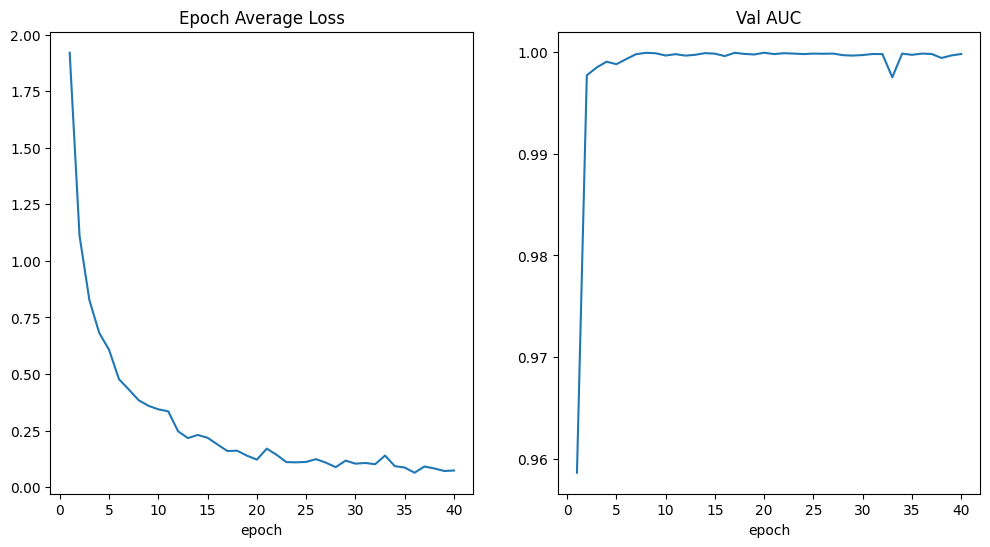

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [20]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 194.11 MB
Max VRAM used during training: 239.13 MB


### Evaluation

In [21]:
model.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [22]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 194.12 MB
Max VRAM used during training: 239.18 MB


In [274]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)

In [275]:
import pandas as pd
df = pd.DataFrame(report).transpose()
df.to_csv(f'axial_full_pretrained_seed{seed}.csv')

In [23]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9855    0.9927        69
           1     0.9464    0.7794    0.8548        68
           2     0.7917    0.8261    0.8085        69
           3     0.9273    0.7846    0.8500        65
           4     0.7403    0.8769    0.8028        65
           5     0.9833    0.8939    0.9365        66
           6     1.0000    0.9643    0.9818        28
           7     1.0000    1.0000    1.0000        21
           8     0.9545    1.0000    0.9767        21
           9     0.8243    0.8841    0.8531        69
          10     0.7692    0.8696    0.8163        69

    accuracy                         0.8770       610
   macro avg     0.9034    0.8968    0.8976       610
weighted avg     0.8857    0.8770    0.8784       610



## Unpretrained

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

In [25]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images

        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "axial_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.8043
1


Epochs:   2%|▎         | 1/40 [00:17<11:15, 17.32s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9928 current accuracy: 0.8447 best AUC: 0.9928 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.0266
1


Epochs:   5%|▌         | 2/40 [00:34<11:02, 17.43s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9964 current accuracy: 0.8882 best AUC: 0.9964 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 0.7228
1


Epochs:   8%|▊         | 3/40 [00:52<10:46, 17.48s/it]

saved new best metric model
current epoch: 3 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.6000


Epochs:  10%|█         | 4/40 [01:09<10:26, 17.42s/it]

1
current epoch: 4 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 3
----------
epoch 5/40
epoch 5 average loss: 0.5014


Epochs:  12%|█▎        | 5/40 [01:26<10:08, 17.37s/it]

1
current epoch: 5 current AUC: 0.9989 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 3
----------
epoch 6/40
epoch 6 average loss: 0.4766


Epochs:  15%|█▌        | 6/40 [01:44<09:46, 17.26s/it]

1
current epoch: 6 current AUC: 0.9988 current accuracy: 0.9193 best AUC: 1.0000 at epoch: 3
----------
epoch 7/40
epoch 7 average loss: 0.4806


Epochs:  18%|█▊        | 7/40 [02:01<09:28, 17.23s/it]

1
current epoch: 7 current AUC: 0.9951 current accuracy: 0.8944 best AUC: 1.0000 at epoch: 3
----------
epoch 8/40
epoch 8 average loss: 0.3824


Epochs:  20%|██        | 8/40 [02:18<09:09, 17.19s/it]

1
current epoch: 8 current AUC: 0.9991 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 3
----------
epoch 9/40
epoch 9 average loss: 0.3814


Epochs:  22%|██▎       | 9/40 [02:35<08:51, 17.14s/it]

1
current epoch: 9 current AUC: 0.9995 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 3
----------
epoch 10/40
epoch 10 average loss: 0.3137


Epochs:  25%|██▌       | 10/40 [02:52<08:33, 17.11s/it]

1
current epoch: 10 current AUC: 0.9996 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 3
----------
epoch 11/40
epoch 11 average loss: 0.2683


Epochs:  28%|██▊       | 11/40 [03:09<08:17, 17.14s/it]

1
current epoch: 11 current AUC: 0.9992 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 3
----------
epoch 12/40
epoch 12 average loss: 0.2361


Epochs:  30%|███       | 12/40 [03:26<07:58, 17.09s/it]

1
current epoch: 12 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 3
----------
epoch 13/40
epoch 13 average loss: 0.2025


Epochs:  32%|███▎      | 13/40 [03:43<07:42, 17.12s/it]

1
current epoch: 13 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 3
----------
epoch 14/40
epoch 14 average loss: 0.2142


Epochs:  35%|███▌      | 14/40 [04:00<07:24, 17.10s/it]

1
current epoch: 14 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 3
----------
epoch 15/40
epoch 15 average loss: 0.1803


Epochs:  38%|███▊      | 15/40 [04:17<07:07, 17.08s/it]

1
current epoch: 15 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 3
----------
epoch 16/40
epoch 16 average loss: 0.1816


Epochs:  40%|████      | 16/40 [04:34<06:50, 17.11s/it]

1
current epoch: 16 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 3
----------
epoch 17/40
epoch 17 average loss: 0.1817


Epochs:  42%|████▎     | 17/40 [04:52<06:34, 17.15s/it]

1
current epoch: 17 current AUC: 0.9996 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 3
----------
epoch 18/40
epoch 18 average loss: 0.1842


Epochs:  45%|████▌     | 18/40 [05:09<06:17, 17.17s/it]

1
current epoch: 18 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 3
----------
epoch 19/40
epoch 19 average loss: 0.1522


Epochs:  48%|████▊     | 19/40 [05:26<05:59, 17.14s/it]

1
current epoch: 19 current AUC: 0.9997 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 3
----------
epoch 20/40
epoch 20 average loss: 0.1443


Epochs:  50%|█████     | 20/40 [05:43<05:41, 17.09s/it]

1
current epoch: 20 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 3
----------
epoch 21/40
epoch 21 average loss: 0.1511
1


Epochs:  52%|█████▎    | 21/40 [06:01<05:27, 17.22s/it]

saved new best metric model
current epoch: 21 current AUC: 1.0000 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 21
----------
epoch 22/40
epoch 22 average loss: 0.1200


Epochs:  55%|█████▌    | 22/40 [06:17<05:08, 17.13s/it]

1
current epoch: 22 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 21
----------
epoch 23/40
epoch 23 average loss: 0.1069


Epochs:  57%|█████▊    | 23/40 [06:34<04:50, 17.10s/it]

1
current epoch: 23 current AUC: 0.9999 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 21
----------
epoch 24/40
epoch 24 average loss: 0.0796


Epochs:  60%|██████    | 24/40 [06:51<04:32, 17.06s/it]

1
current epoch: 24 current AUC: 0.9999 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 21
----------
epoch 25/40
epoch 25 average loss: 0.1375


Epochs:  62%|██████▎   | 25/40 [07:09<04:16, 17.09s/it]

1
current epoch: 25 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 21
----------
epoch 26/40
epoch 26 average loss: 0.1513


Epochs:  65%|██████▌   | 26/40 [07:26<04:00, 17.16s/it]

1
current epoch: 26 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 21
----------
epoch 27/40
epoch 27 average loss: 0.0853


Epochs:  68%|██████▊   | 27/40 [07:43<03:43, 17.19s/it]

1
current epoch: 27 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 21
----------
epoch 28/40
epoch 28 average loss: 0.1112


Epochs:  70%|███████   | 28/40 [08:00<03:25, 17.14s/it]

1
current epoch: 28 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 21
----------
epoch 29/40
epoch 29 average loss: 0.0800


Epochs:  72%|███████▎  | 29/40 [08:17<03:06, 17.00s/it]

1
current epoch: 29 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 21
----------
epoch 30/40
epoch 30 average loss: 0.0829


Epochs:  75%|███████▌  | 30/40 [08:34<02:50, 17.05s/it]

1
current epoch: 30 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 21
----------
epoch 31/40
epoch 31 average loss: 0.0897


Epochs:  78%|███████▊  | 31/40 [08:51<02:32, 16.99s/it]

1
current epoch: 31 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 21
----------
epoch 32/40
epoch 32 average loss: 0.1414


Epochs:  80%|████████  | 32/40 [09:08<02:15, 17.00s/it]

1
current epoch: 32 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 21
----------
epoch 33/40
epoch 33 average loss: 0.1024


Epochs:  82%|████████▎ | 33/40 [09:25<01:58, 16.99s/it]

1
current epoch: 33 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 21
----------
epoch 34/40
epoch 34 average loss: 0.0912


Epochs:  85%|████████▌ | 34/40 [09:42<01:42, 17.07s/it]

1
current epoch: 34 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 21
----------
epoch 35/40
epoch 35 average loss: 0.0532


Epochs:  88%|████████▊ | 35/40 [09:59<01:24, 16.99s/it]

1
current epoch: 35 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 21
----------
epoch 36/40
epoch 36 average loss: 0.1034


Epochs:  90%|█████████ | 36/40 [10:16<01:08, 17.01s/it]

1
current epoch: 36 current AUC: 0.9980 current accuracy: 0.8758 best AUC: 1.0000 at epoch: 21
----------
epoch 37/40
epoch 37 average loss: 0.0882


Epochs:  92%|█████████▎| 37/40 [10:33<00:51, 17.02s/it]

1
current epoch: 37 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 21
----------
epoch 38/40
epoch 38 average loss: 0.1085


Epochs:  95%|█████████▌| 38/40 [10:50<00:34, 17.05s/it]

1
current epoch: 38 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 21
----------
epoch 39/40
epoch 39 average loss: 0.0651


Epochs:  98%|█████████▊| 39/40 [11:07<00:17, 17.08s/it]

1
current epoch: 39 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 21
----------
epoch 40/40
epoch 40 average loss: 0.0442


Epochs: 100%|██████████| 40/40 [11:24<00:00, 17.12s/it]

1
current epoch: 40 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 21
train completed, best_metric: 1.0000 at epoch: 21


In [26]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 684.86 seconds
CPU time used: 8198.15 seconds
Memory used: 127.70 MB
GPU Memory Used: 194.14 MB
Max GPU Memory Used: 255.69 MB


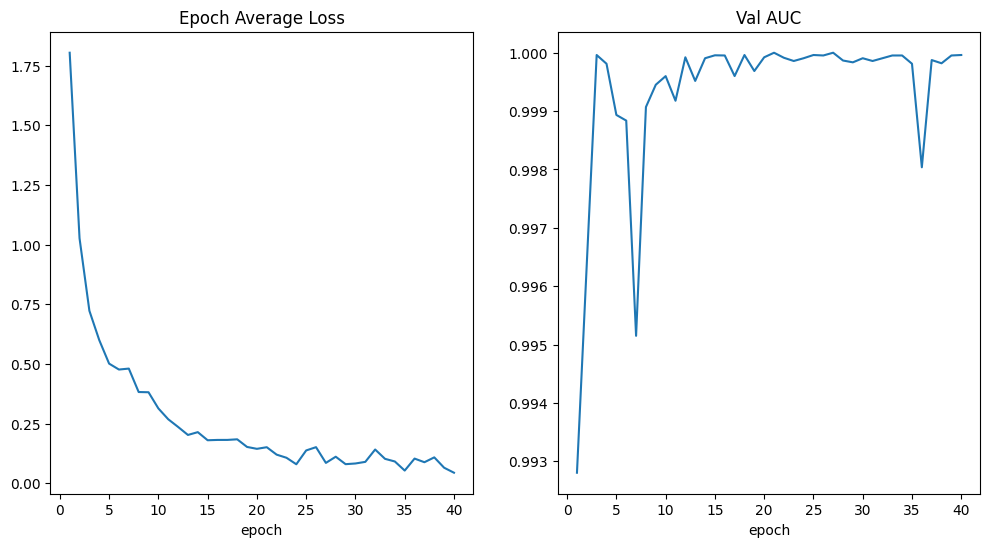

In [27]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [28]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 194.14 MB
Max VRAM used during training: 255.69 MB


### Evaluation

In [29]:
model.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [281]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)

In [282]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'axial_full_unpretrained_seed{seed}.csv')

In [30]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9853    0.9710    0.9781        69
           1     0.6914    0.8235    0.7517        68
           2     0.7183    0.7391    0.7286        69
           3     0.7195    0.9077    0.8027        65
           4     0.9333    0.8615    0.8960        65
           5     0.8939    0.8939    0.8939        66
           6     1.0000    0.9286    0.9630        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9206    0.8406    0.8788        69
          10     1.0000    0.7391    0.8500        69

    accuracy                         0.8607       610
   macro avg     0.8966    0.8823    0.8857       610
weighted avg     0.8746    0.8607    0.8632       610



In [31]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 194.13 MB
Max VRAM used during training: 255.69 MB


# Coronal and sagittal parts

## Training cycle for the coronal part

## Pretrained

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

In [77]:
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []
# writer = SummaryWriter()

# start_time = time.time()
# process = psutil.Process()
# start_cpu = process.cpu_times()
# start_mem = process.memory_info().rss / 1024**2

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "coronal_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.9455


Epochs:   2%|▎         | 1/40 [00:16<10:53, 16.75s/it]

1
current epoch: 1 current AUC: 0.9472 current accuracy: 0.6770 best AUC: 1.0000 at epoch: 16
----------
epoch 2/40
epoch 2 average loss: 1.2327


Epochs:   5%|▌         | 2/40 [00:33<10:37, 16.79s/it]

1
current epoch: 2 current AUC: 0.9637 current accuracy: 0.6770 best AUC: 1.0000 at epoch: 16
----------
epoch 3/40
epoch 3 average loss: 0.9499


Epochs:   8%|▊         | 3/40 [00:50<10:21, 16.80s/it]

1
current epoch: 3 current AUC: 0.9729 current accuracy: 0.7578 best AUC: 1.0000 at epoch: 16
----------
epoch 4/40
epoch 4 average loss: 0.8049


Epochs:  10%|█         | 4/40 [01:07<10:02, 16.74s/it]

1
current epoch: 4 current AUC: 0.9861 current accuracy: 0.8075 best AUC: 1.0000 at epoch: 16
----------
epoch 5/40
epoch 5 average loss: 0.7257


Epochs:  12%|█▎        | 5/40 [01:24<09:51, 16.90s/it]

1
current epoch: 5 current AUC: 0.9789 current accuracy: 0.7391 best AUC: 1.0000 at epoch: 16
----------
epoch 6/40
epoch 6 average loss: 0.6667


Epochs:  15%|█▌        | 6/40 [01:41<09:36, 16.96s/it]

1
current epoch: 6 current AUC: 0.9897 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 16
----------
epoch 7/40
epoch 7 average loss: 0.6181


Epochs:  18%|█▊        | 7/40 [01:58<09:17, 16.89s/it]

1
current epoch: 7 current AUC: 0.9910 current accuracy: 0.8944 best AUC: 1.0000 at epoch: 16
----------
epoch 8/40
epoch 8 average loss: 0.5931


Epochs:  20%|██        | 8/40 [02:15<09:03, 16.99s/it]

1
current epoch: 8 current AUC: 0.9935 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 16
----------
epoch 9/40
epoch 9 average loss: 0.5532


Epochs:  22%|██▎       | 9/40 [02:31<08:44, 16.92s/it]

1
current epoch: 9 current AUC: 0.9864 current accuracy: 0.8012 best AUC: 1.0000 at epoch: 16
----------
epoch 10/40
epoch 10 average loss: 0.4916


Epochs:  25%|██▌       | 10/40 [02:48<08:27, 16.91s/it]

1
current epoch: 10 current AUC: 0.9966 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 16
----------
epoch 11/40
epoch 11 average loss: 0.4457


Epochs:  28%|██▊       | 11/40 [03:05<08:09, 16.87s/it]

1
current epoch: 11 current AUC: 0.9899 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 16
----------
epoch 12/40
epoch 12 average loss: 0.4038


Epochs:  30%|███       | 12/40 [03:22<07:52, 16.89s/it]

1
current epoch: 12 current AUC: 0.9949 current accuracy: 0.9068 best AUC: 1.0000 at epoch: 16
----------
epoch 13/40
epoch 13 average loss: 0.4061


Epochs:  32%|███▎      | 13/40 [03:39<07:34, 16.83s/it]

1
current epoch: 13 current AUC: 0.9857 current accuracy: 0.8261 best AUC: 1.0000 at epoch: 16
----------
epoch 14/40
epoch 14 average loss: 0.3946


Epochs:  35%|███▌      | 14/40 [03:56<07:20, 16.94s/it]

1
current epoch: 14 current AUC: 0.9934 current accuracy: 0.8758 best AUC: 1.0000 at epoch: 16
----------
epoch 15/40
epoch 15 average loss: 0.3291


Epochs:  38%|███▊      | 15/40 [04:13<07:03, 16.94s/it]

1
current epoch: 15 current AUC: 0.9979 current accuracy: 0.9193 best AUC: 1.0000 at epoch: 16
----------
epoch 16/40
epoch 16 average loss: 0.3503


Epochs:  40%|████      | 16/40 [04:30<06:47, 16.97s/it]

1
current epoch: 16 current AUC: 0.9923 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 16
----------
epoch 17/40
epoch 17 average loss: 0.3483


Epochs:  42%|████▎     | 17/40 [04:47<06:29, 16.95s/it]

1
current epoch: 17 current AUC: 0.9929 current accuracy: 0.8882 best AUC: 1.0000 at epoch: 16
----------
epoch 18/40
epoch 18 average loss: 0.2838


Epochs:  45%|████▌     | 18/40 [05:04<06:11, 16.89s/it]

1
current epoch: 18 current AUC: 0.9863 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 16
----------
epoch 19/40
epoch 19 average loss: 0.2991


Epochs:  48%|████▊     | 19/40 [05:21<05:55, 16.95s/it]

1
current epoch: 19 current AUC: 0.9964 current accuracy: 0.9068 best AUC: 1.0000 at epoch: 16
----------
epoch 20/40
epoch 20 average loss: 0.2910


Epochs:  50%|█████     | 20/40 [05:37<05:36, 16.82s/it]

1
current epoch: 20 current AUC: 0.9850 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 16
----------
epoch 21/40
epoch 21 average loss: 0.2822


Epochs:  52%|█████▎    | 21/40 [05:54<05:21, 16.91s/it]

1
current epoch: 21 current AUC: 0.9845 current accuracy: 0.8447 best AUC: 1.0000 at epoch: 16
----------
epoch 22/40
epoch 22 average loss: 0.2770


Epochs:  55%|█████▌    | 22/40 [06:11<05:03, 16.86s/it]

1
current epoch: 22 current AUC: 0.9855 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 16
----------
epoch 23/40
epoch 23 average loss: 0.2465


Epochs:  57%|█████▊    | 23/40 [06:28<04:47, 16.92s/it]

1
current epoch: 23 current AUC: 0.9864 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 16
----------
epoch 24/40
epoch 24 average loss: 0.2609


Epochs:  60%|██████    | 24/40 [06:45<04:31, 16.94s/it]

1
current epoch: 24 current AUC: 0.9954 current accuracy: 0.8882 best AUC: 1.0000 at epoch: 16
----------
epoch 25/40
epoch 25 average loss: 0.2416


Epochs:  62%|██████▎   | 25/40 [07:02<04:13, 16.90s/it]

1
current epoch: 25 current AUC: 0.9896 current accuracy: 0.8820 best AUC: 1.0000 at epoch: 16
----------
epoch 26/40
epoch 26 average loss: 0.2415


Epochs:  65%|██████▌   | 26/40 [07:19<03:56, 16.89s/it]

1
current epoch: 26 current AUC: 0.9910 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 16
----------
epoch 27/40
epoch 27 average loss: 0.2437


Epochs:  68%|██████▊   | 27/40 [07:36<03:39, 16.91s/it]

1
current epoch: 27 current AUC: 0.9928 current accuracy: 0.9006 best AUC: 1.0000 at epoch: 16
----------
epoch 28/40
epoch 28 average loss: 0.1766


Epochs:  70%|███████   | 28/40 [07:53<03:22, 16.87s/it]

1
current epoch: 28 current AUC: 0.9894 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 16
----------
epoch 29/40
epoch 29 average loss: 0.1922


Epochs:  72%|███████▎  | 29/40 [08:09<03:05, 16.83s/it]

1
current epoch: 29 current AUC: 0.9976 current accuracy: 0.8944 best AUC: 1.0000 at epoch: 16
----------
epoch 30/40
epoch 30 average loss: 0.1842


Epochs:  75%|███████▌  | 30/40 [08:26<02:48, 16.89s/it]

1
current epoch: 30 current AUC: 0.9950 current accuracy: 0.9317 best AUC: 1.0000 at epoch: 16
----------
epoch 31/40
epoch 31 average loss: 0.2149


Epochs:  78%|███████▊  | 31/40 [08:44<02:32, 16.98s/it]

1
current epoch: 31 current AUC: 0.9809 current accuracy: 0.8447 best AUC: 1.0000 at epoch: 16
----------
epoch 32/40
epoch 32 average loss: 0.1707


Epochs:  80%|████████  | 32/40 [09:01<02:15, 16.98s/it]

1
current epoch: 32 current AUC: 0.9880 current accuracy: 0.8758 best AUC: 1.0000 at epoch: 16
----------
epoch 33/40
epoch 33 average loss: 0.1497


Epochs:  82%|████████▎ | 33/40 [09:17<01:58, 16.94s/it]

1
current epoch: 33 current AUC: 0.9964 current accuracy: 0.9317 best AUC: 1.0000 at epoch: 16
----------
epoch 34/40
epoch 34 average loss: 0.1900


Epochs:  85%|████████▌ | 34/40 [09:34<01:41, 16.92s/it]

1
current epoch: 34 current AUC: 0.9888 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 16
----------
epoch 35/40
epoch 35 average loss: 0.1651


Epochs:  88%|████████▊ | 35/40 [09:51<01:24, 16.92s/it]

1
current epoch: 35 current AUC: 0.9927 current accuracy: 0.9006 best AUC: 1.0000 at epoch: 16
----------
epoch 36/40
epoch 36 average loss: 0.2062


Epochs:  90%|█████████ | 36/40 [10:08<01:07, 16.93s/it]

1
current epoch: 36 current AUC: 0.9807 current accuracy: 0.8199 best AUC: 1.0000 at epoch: 16
----------
epoch 37/40
epoch 37 average loss: 0.1981


Epochs:  92%|█████████▎| 37/40 [10:25<00:50, 16.92s/it]

1
current epoch: 37 current AUC: 0.9806 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 16
----------
epoch 38/40
epoch 38 average loss: 0.1520


Epochs:  95%|█████████▌| 38/40 [10:42<00:33, 16.94s/it]

1
current epoch: 38 current AUC: 0.9960 current accuracy: 0.9255 best AUC: 1.0000 at epoch: 16
----------
epoch 39/40
epoch 39 average loss: 0.1396


Epochs:  98%|█████████▊| 39/40 [10:59<00:16, 16.98s/it]

1
current epoch: 39 current AUC: 0.9944 current accuracy: 0.9130 best AUC: 1.0000 at epoch: 16
----------
epoch 40/40
epoch 40 average loss: 0.1310


Epochs: 100%|██████████| 40/40 [11:16<00:00, 16.92s/it]

1
current epoch: 40 current AUC: 0.9915 current accuracy: 0.8696 best AUC: 1.0000 at epoch: 16
train completed, best_metric: 1.0000 at epoch: 16


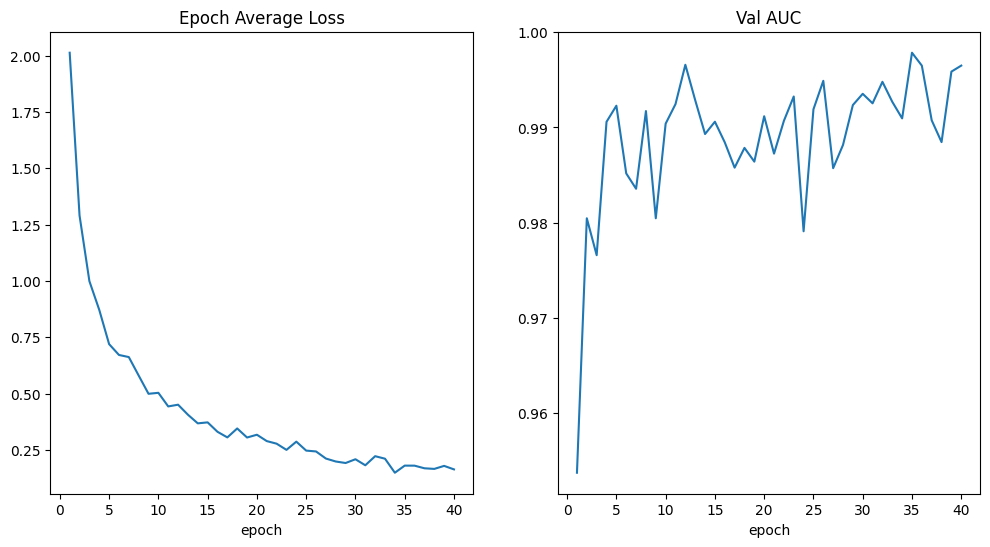

In [34]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [35]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 678.44 seconds
CPU time used: 8110.50 seconds
Memory used: -44.46 MB
GPU Memory Used: 194.25 MB
Max GPU Memory Used: 238.64 MB


In [36]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 194.25 MB
Max VRAM used during training: 238.64 MB


### Evaluation

In [37]:
model.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [38]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.6786    0.5588    0.6129        68
           2     0.6364    0.6087    0.6222        69
           3     0.5591    0.8000    0.6582        65
           4     0.6829    0.4308    0.5283        65
           5     0.8228    0.9848    0.8966        66
           6     0.9655    1.0000    0.9825        28
           7     1.0000    0.9524    0.9756        21
           8     0.9130    1.0000    0.9545        21
           9     0.8657    0.8406    0.8529        69
          10     0.9848    0.9420    0.9630        69

    accuracy                         0.7967       610
   macro avg     0.8268    0.8289    0.8218       610
weighted avg     0.8000    0.7967    0.7914       610



In [289]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'coronal_full_pretrained_seed{seed}.csv')

In [39]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 194.24 MB
Max VRAM used during training: 238.69 MB


## Unpretrained

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

In [41]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "coronal_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.8091
1


Epochs:   2%|▎         | 1/40 [00:17<11:14, 17.29s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9579 current accuracy: 0.5217 best AUC: 0.9579 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.2000
1


Epochs:   5%|▌         | 2/40 [00:34<10:59, 17.36s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9803 current accuracy: 0.6708 best AUC: 0.9803 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 1.0431
1


Epochs:   8%|▊         | 3/40 [00:52<10:43, 17.38s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9898 current accuracy: 0.7950 best AUC: 0.9898 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.8842


Epochs:  10%|█         | 4/40 [01:08<10:18, 17.17s/it]

1
current epoch: 4 current AUC: 0.9858 current accuracy: 0.6708 best AUC: 0.9898 at epoch: 3
----------
epoch 5/40
epoch 5 average loss: 0.7898
1


Epochs:  12%|█▎        | 5/40 [01:26<10:06, 17.32s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9904 current accuracy: 0.7516 best AUC: 0.9904 at epoch: 5
----------
epoch 6/40
epoch 6 average loss: 0.6889
1


Epochs:  15%|█▌        | 6/40 [01:43<09:50, 17.36s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9950 current accuracy: 0.8571 best AUC: 0.9950 at epoch: 6
----------
epoch 7/40
epoch 7 average loss: 0.6649


Epochs:  18%|█▊        | 7/40 [02:00<09:25, 17.15s/it]

1
current epoch: 7 current AUC: 0.9905 current accuracy: 0.8261 best AUC: 0.9950 at epoch: 6
----------
epoch 8/40
epoch 8 average loss: 0.6245


Epochs:  20%|██        | 8/40 [02:17<09:08, 17.13s/it]

1
current epoch: 8 current AUC: 0.9836 current accuracy: 0.7702 best AUC: 0.9950 at epoch: 6
----------
epoch 9/40
epoch 9 average loss: 0.5699


Epochs:  22%|██▎       | 9/40 [02:34<08:49, 17.08s/it]

1
current epoch: 9 current AUC: 0.9855 current accuracy: 0.8261 best AUC: 0.9950 at epoch: 6
----------
epoch 10/40
epoch 10 average loss: 0.5462


Epochs:  25%|██▌       | 10/40 [02:51<08:30, 17.01s/it]

1
current epoch: 10 current AUC: 0.9882 current accuracy: 0.8012 best AUC: 0.9950 at epoch: 6
----------
epoch 11/40
epoch 11 average loss: 0.5255


Epochs:  28%|██▊       | 11/40 [03:08<08:12, 16.98s/it]

1
current epoch: 11 current AUC: 0.9897 current accuracy: 0.8261 best AUC: 0.9950 at epoch: 6
----------
epoch 12/40
epoch 12 average loss: 0.4475


Epochs:  30%|███       | 12/40 [03:25<07:54, 16.96s/it]

1
current epoch: 12 current AUC: 0.9869 current accuracy: 0.8261 best AUC: 0.9950 at epoch: 6
----------
epoch 13/40
epoch 13 average loss: 0.4056


Epochs:  32%|███▎      | 13/40 [03:42<07:36, 16.90s/it]

1
current epoch: 13 current AUC: 0.9884 current accuracy: 0.8447 best AUC: 0.9950 at epoch: 6
----------
epoch 14/40
epoch 14 average loss: 0.3860


Epochs:  35%|███▌      | 14/40 [03:59<07:20, 16.96s/it]

1
current epoch: 14 current AUC: 0.9887 current accuracy: 0.8509 best AUC: 0.9950 at epoch: 6
----------
epoch 15/40
epoch 15 average loss: 0.3703


Epochs:  38%|███▊      | 15/40 [04:16<07:02, 16.89s/it]

1
current epoch: 15 current AUC: 0.9912 current accuracy: 0.8199 best AUC: 0.9950 at epoch: 6
----------
epoch 16/40
epoch 16 average loss: 0.3843


Epochs:  40%|████      | 16/40 [04:33<06:46, 16.96s/it]

1
current epoch: 16 current AUC: 0.9875 current accuracy: 0.8323 best AUC: 0.9950 at epoch: 6
----------
epoch 17/40
epoch 17 average loss: 0.3196


Epochs:  42%|████▎     | 17/40 [04:50<06:31, 17.01s/it]

1
current epoch: 17 current AUC: 0.9920 current accuracy: 0.8323 best AUC: 0.9950 at epoch: 6
----------
epoch 18/40
epoch 18 average loss: 0.3367


Epochs:  45%|████▌     | 18/40 [05:07<06:12, 16.95s/it]

1
current epoch: 18 current AUC: 0.9861 current accuracy: 0.8075 best AUC: 0.9950 at epoch: 6
----------
epoch 19/40
epoch 19 average loss: 0.3568


Epochs:  48%|████▊     | 19/40 [05:23<05:55, 16.92s/it]

1
current epoch: 19 current AUC: 0.9915 current accuracy: 0.8571 best AUC: 0.9950 at epoch: 6
----------
epoch 20/40
epoch 20 average loss: 0.3301


Epochs:  50%|█████     | 20/40 [05:40<05:36, 16.84s/it]

1
current epoch: 20 current AUC: 0.9926 current accuracy: 0.8323 best AUC: 0.9950 at epoch: 6
----------
epoch 21/40
epoch 21 average loss: 0.3039


Epochs:  52%|█████▎    | 21/40 [05:57<05:20, 16.89s/it]

1
current epoch: 21 current AUC: 0.9884 current accuracy: 0.8323 best AUC: 0.9950 at epoch: 6
----------
epoch 22/40
epoch 22 average loss: 0.2880


Epochs:  55%|█████▌    | 22/40 [06:14<05:05, 16.99s/it]

1
current epoch: 22 current AUC: 0.9925 current accuracy: 0.8509 best AUC: 0.9950 at epoch: 6
----------
epoch 23/40
epoch 23 average loss: 0.3028


Epochs:  57%|█████▊    | 23/40 [06:31<04:48, 16.96s/it]

1
current epoch: 23 current AUC: 0.9921 current accuracy: 0.8509 best AUC: 0.9950 at epoch: 6
----------
epoch 24/40
epoch 24 average loss: 0.2577


Epochs:  60%|██████    | 24/40 [06:48<04:30, 16.93s/it]

1
current epoch: 24 current AUC: 0.9890 current accuracy: 0.8323 best AUC: 0.9950 at epoch: 6
----------
epoch 25/40
epoch 25 average loss: 0.2360


Epochs:  62%|██████▎   | 25/40 [07:05<04:13, 16.93s/it]

1
current epoch: 25 current AUC: 0.9873 current accuracy: 0.8323 best AUC: 0.9950 at epoch: 6
----------
epoch 26/40
epoch 26 average loss: 0.2019


Epochs:  65%|██████▌   | 26/40 [07:22<03:58, 17.02s/it]

1
current epoch: 26 current AUC: 0.9900 current accuracy: 0.8509 best AUC: 0.9950 at epoch: 6
----------
epoch 27/40
epoch 27 average loss: 0.2595


Epochs:  68%|██████▊   | 27/40 [07:39<03:41, 17.05s/it]

1
current epoch: 27 current AUC: 0.9894 current accuracy: 0.8696 best AUC: 0.9950 at epoch: 6
----------
epoch 28/40
epoch 28 average loss: 0.2194


Epochs:  70%|███████   | 28/40 [07:56<03:24, 17.00s/it]

1
current epoch: 28 current AUC: 0.9881 current accuracy: 0.8447 best AUC: 0.9950 at epoch: 6
----------
epoch 29/40
epoch 29 average loss: 0.1869


Epochs:  72%|███████▎  | 29/40 [08:13<03:06, 16.93s/it]

1
current epoch: 29 current AUC: 0.9871 current accuracy: 0.8447 best AUC: 0.9950 at epoch: 6
----------
epoch 30/40
epoch 30 average loss: 0.1973


Epochs:  75%|███████▌  | 30/40 [08:30<02:48, 16.90s/it]

1
current epoch: 30 current AUC: 0.9857 current accuracy: 0.8137 best AUC: 0.9950 at epoch: 6
----------
epoch 31/40
epoch 31 average loss: 0.2211


Epochs:  78%|███████▊  | 31/40 [08:47<02:31, 16.87s/it]

1
current epoch: 31 current AUC: 0.9871 current accuracy: 0.8323 best AUC: 0.9950 at epoch: 6
----------
epoch 32/40
epoch 32 average loss: 0.1870


Epochs:  80%|████████  | 32/40 [09:03<02:14, 16.84s/it]

1
current epoch: 32 current AUC: 0.9931 current accuracy: 0.9130 best AUC: 0.9950 at epoch: 6
----------
epoch 33/40
epoch 33 average loss: 0.1428
1


Epochs:  82%|████████▎ | 33/40 [09:21<01:59, 17.03s/it]

saved new best metric model
current epoch: 33 current AUC: 0.9952 current accuracy: 0.9130 best AUC: 0.9952 at epoch: 33
----------
epoch 34/40
epoch 34 average loss: 0.1714
1


Epochs:  85%|████████▌ | 34/40 [09:38<01:42, 17.16s/it]

saved new best metric model
current epoch: 34 current AUC: 0.9956 current accuracy: 0.9006 best AUC: 0.9956 at epoch: 34
----------
epoch 35/40
epoch 35 average loss: 0.1761


Epochs:  88%|████████▊ | 35/40 [09:56<01:25, 17.17s/it]

1
current epoch: 35 current AUC: 0.9896 current accuracy: 0.8820 best AUC: 0.9956 at epoch: 34
----------
epoch 36/40
epoch 36 average loss: 0.1373


Epochs:  90%|█████████ | 36/40 [10:12<01:08, 17.01s/it]

1
current epoch: 36 current AUC: 0.9919 current accuracy: 0.8571 best AUC: 0.9956 at epoch: 34
----------
epoch 37/40
epoch 37 average loss: 0.1701


Epochs:  92%|█████████▎| 37/40 [10:29<00:51, 17.04s/it]

1
current epoch: 37 current AUC: 0.9935 current accuracy: 0.9006 best AUC: 0.9956 at epoch: 34
----------
epoch 38/40
epoch 38 average loss: 0.1443


Epochs:  95%|█████████▌| 38/40 [10:46<00:34, 17.05s/it]

1
current epoch: 38 current AUC: 0.9894 current accuracy: 0.8571 best AUC: 0.9956 at epoch: 34
----------
epoch 39/40
epoch 39 average loss: 0.1230


Epochs:  98%|█████████▊| 39/40 [11:03<00:17, 17.05s/it]

1
current epoch: 39 current AUC: 0.9901 current accuracy: 0.8509 best AUC: 0.9956 at epoch: 34
----------
epoch 40/40
epoch 40 average loss: 0.1618


Epochs: 100%|██████████| 40/40 [11:20<00:00, 17.02s/it]

1
current epoch: 40 current AUC: 0.9902 current accuracy: 0.8447 best AUC: 0.9956 at epoch: 34
train completed, best_metric: 0.9956 at epoch: 34


In [42]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 680.61 seconds
CPU time used: 8136.81 seconds
Memory used: 1.50 MB
GPU Memory Used: 193.39 MB
Max GPU Memory Used: 251.94 MB


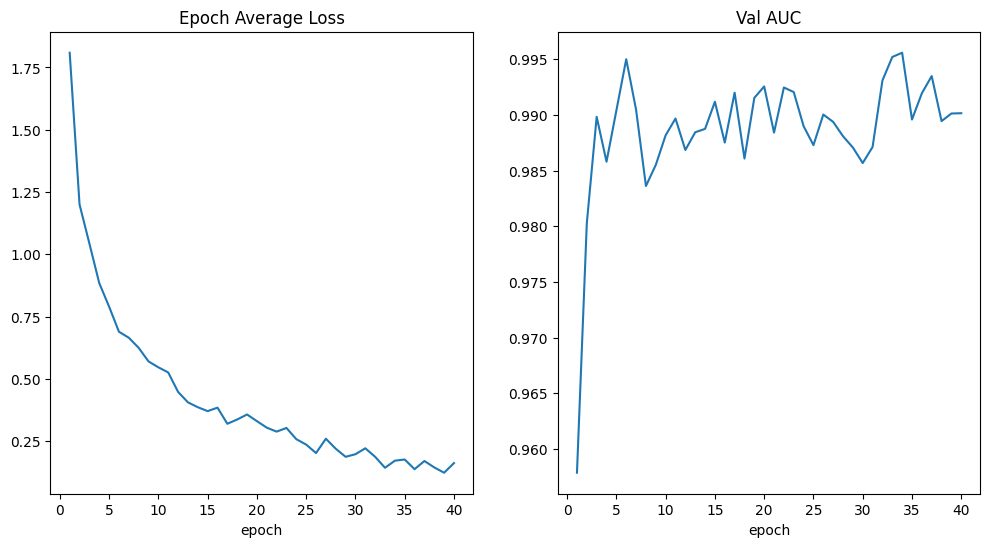

In [43]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [44]:
model.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [45]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.0455    0.0145    0.0220        69
           1     0.2459    0.2206    0.2326        68
           2     0.1889    0.2464    0.2138        69
           3     0.2500    0.0769    0.1176        65
           4     0.3333    0.0308    0.0563        65
           5     0.3571    0.8333    0.5000        66
           6     0.0000    0.0000    0.0000        28
           7     0.0000    0.0000    0.0000        21
           8     0.5172    0.7143    0.6000        21
           9     0.1768    0.5072    0.2622        69
          10     0.0370    0.0145    0.0208        69

    accuracy                         0.2393       610
   macro avg     0.1956    0.2417    0.1841       610
weighted avg     0.1967    0.2393    0.1779       610



In [295]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'coronal_full_unpretrained_seed{seed}.csv')

In [46]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 193.38 MB
Max VRAM used during training: 251.94 MB


## Training cycle for the sagittal part

## Pretrained

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

In [79]:
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []
# writer = SummaryWriter()

# start_time = time.time()
# process = psutil.Process()
# start_cpu = process.cpu_times()
# start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "sagittal_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.9710


Epochs:   2%|▎         | 1/40 [00:16<10:55, 16.80s/it]

1
current epoch: 1 current AUC: 0.9593 current accuracy: 0.5901 best AUC: 1.0000 at epoch: 16
----------
epoch 2/40
epoch 2 average loss: 1.2531


Epochs:   5%|▌         | 2/40 [00:33<10:40, 16.85s/it]

1
current epoch: 2 current AUC: 0.9762 current accuracy: 0.7702 best AUC: 1.0000 at epoch: 16
----------
epoch 3/40
epoch 3 average loss: 1.0119


Epochs:   8%|▊         | 3/40 [00:50<10:25, 16.92s/it]

1
current epoch: 3 current AUC: 0.9898 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 16
----------
epoch 4/40
epoch 4 average loss: 0.9193


Epochs:  10%|█         | 4/40 [01:07<10:09, 16.93s/it]

1
current epoch: 4 current AUC: 0.9628 current accuracy: 0.8199 best AUC: 1.0000 at epoch: 16
----------
epoch 5/40
epoch 5 average loss: 0.8107


Epochs:  12%|█▎        | 5/40 [01:24<09:52, 16.92s/it]

1
current epoch: 5 current AUC: 0.9885 current accuracy: 0.8323 best AUC: 1.0000 at epoch: 16
----------
epoch 6/40
epoch 6 average loss: 0.7133


Epochs:  15%|█▌        | 6/40 [01:41<09:35, 16.94s/it]

1
current epoch: 6 current AUC: 0.9775 current accuracy: 0.7640 best AUC: 1.0000 at epoch: 16
----------
epoch 7/40
epoch 7 average loss: 0.6812


Epochs:  18%|█▊        | 7/40 [01:58<09:18, 16.92s/it]

1
current epoch: 7 current AUC: 0.9932 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 16
----------
epoch 8/40
epoch 8 average loss: 0.6155


Epochs:  20%|██        | 8/40 [02:15<09:01, 16.91s/it]

1
current epoch: 8 current AUC: 0.9830 current accuracy: 0.8137 best AUC: 1.0000 at epoch: 16
----------
epoch 9/40
epoch 9 average loss: 0.5949


Epochs:  22%|██▎       | 9/40 [02:32<08:44, 16.92s/it]

1
current epoch: 9 current AUC: 0.9861 current accuracy: 0.8199 best AUC: 1.0000 at epoch: 16
----------
epoch 10/40
epoch 10 average loss: 0.5228


Epochs:  25%|██▌       | 10/40 [02:49<08:29, 16.98s/it]

1
current epoch: 10 current AUC: 0.9888 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 16
----------
epoch 11/40
epoch 11 average loss: 0.4427


Epochs:  28%|██▊       | 11/40 [03:06<08:12, 16.99s/it]

1
current epoch: 11 current AUC: 0.9938 current accuracy: 0.9006 best AUC: 1.0000 at epoch: 16
----------
epoch 12/40
epoch 12 average loss: 0.4528


Epochs:  30%|███       | 12/40 [03:23<07:54, 16.96s/it]

1
current epoch: 12 current AUC: 0.9926 current accuracy: 0.8696 best AUC: 1.0000 at epoch: 16
----------
epoch 13/40
epoch 13 average loss: 0.4085


Epochs:  32%|███▎      | 13/40 [03:40<07:39, 17.00s/it]

1
current epoch: 13 current AUC: 0.9924 current accuracy: 0.8882 best AUC: 1.0000 at epoch: 16
----------
epoch 14/40
epoch 14 average loss: 0.3941


Epochs:  35%|███▌      | 14/40 [03:57<07:21, 16.98s/it]

1
current epoch: 14 current AUC: 0.9796 current accuracy: 0.8447 best AUC: 1.0000 at epoch: 16
----------
epoch 15/40
epoch 15 average loss: 0.4302


Epochs:  38%|███▊      | 15/40 [04:14<07:02, 16.92s/it]

1
current epoch: 15 current AUC: 0.9930 current accuracy: 0.8696 best AUC: 1.0000 at epoch: 16
----------
epoch 16/40
epoch 16 average loss: 0.3460


Epochs:  40%|████      | 16/40 [04:30<06:45, 16.88s/it]

1
current epoch: 16 current AUC: 0.9883 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 16
----------
epoch 17/40
epoch 17 average loss: 0.3660


Epochs:  42%|████▎     | 17/40 [04:47<06:28, 16.90s/it]

1
current epoch: 17 current AUC: 0.9880 current accuracy: 0.8758 best AUC: 1.0000 at epoch: 16
----------
epoch 18/40
epoch 18 average loss: 0.3300


Epochs:  45%|████▌     | 18/40 [05:04<06:10, 16.86s/it]

1
current epoch: 18 current AUC: 0.9893 current accuracy: 0.8758 best AUC: 1.0000 at epoch: 16
----------
epoch 19/40
epoch 19 average loss: 0.2730


Epochs:  48%|████▊     | 19/40 [05:21<05:55, 16.95s/it]

1
current epoch: 19 current AUC: 0.9918 current accuracy: 0.8820 best AUC: 1.0000 at epoch: 16
----------
epoch 20/40
epoch 20 average loss: 0.3209


Epochs:  50%|█████     | 20/40 [05:38<05:39, 16.96s/it]

1
current epoch: 20 current AUC: 0.9831 current accuracy: 0.8261 best AUC: 1.0000 at epoch: 16
----------
epoch 21/40
epoch 21 average loss: 0.2814


Epochs:  52%|█████▎    | 21/40 [05:55<05:22, 16.98s/it]

1
current epoch: 21 current AUC: 0.9931 current accuracy: 0.8882 best AUC: 1.0000 at epoch: 16
----------
epoch 22/40
epoch 22 average loss: 0.2551


Epochs:  55%|█████▌    | 22/40 [06:12<05:05, 16.96s/it]

1
current epoch: 22 current AUC: 0.9915 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 16
----------
epoch 23/40
epoch 23 average loss: 0.2976


Epochs:  57%|█████▊    | 23/40 [06:29<04:48, 16.95s/it]

1
current epoch: 23 current AUC: 0.9935 current accuracy: 0.8820 best AUC: 1.0000 at epoch: 16
----------
epoch 24/40
epoch 24 average loss: 0.2456


Epochs:  60%|██████    | 24/40 [06:46<04:31, 16.98s/it]

1
current epoch: 24 current AUC: 0.9975 current accuracy: 0.9255 best AUC: 1.0000 at epoch: 16
----------
epoch 25/40
epoch 25 average loss: 0.2569


Epochs:  62%|██████▎   | 25/40 [07:03<04:13, 16.93s/it]

1
current epoch: 25 current AUC: 0.9966 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 16
----------
epoch 26/40
epoch 26 average loss: 0.2466


Epochs:  65%|██████▌   | 26/40 [07:20<03:57, 16.97s/it]

1
current epoch: 26 current AUC: 0.9849 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 16
----------
epoch 27/40
epoch 27 average loss: 0.2238


Epochs:  68%|██████▊   | 27/40 [07:37<03:39, 16.91s/it]

1
current epoch: 27 current AUC: 0.9886 current accuracy: 0.8758 best AUC: 1.0000 at epoch: 16
----------
epoch 28/40
epoch 28 average loss: 0.2133


Epochs:  70%|███████   | 28/40 [07:54<03:22, 16.91s/it]

1
current epoch: 28 current AUC: 0.9856 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 16
----------
epoch 29/40
epoch 29 average loss: 0.1958


Epochs:  72%|███████▎  | 29/40 [08:11<03:05, 16.90s/it]

1
current epoch: 29 current AUC: 0.9807 current accuracy: 0.7888 best AUC: 1.0000 at epoch: 16
----------
epoch 30/40
epoch 30 average loss: 0.2014


Epochs:  75%|███████▌  | 30/40 [08:27<02:49, 16.91s/it]

1
current epoch: 30 current AUC: 0.9972 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 16
----------
epoch 31/40
epoch 31 average loss: 0.2413


Epochs:  78%|███████▊  | 31/40 [08:44<02:31, 16.87s/it]

1
current epoch: 31 current AUC: 0.9916 current accuracy: 0.8758 best AUC: 1.0000 at epoch: 16
----------
epoch 32/40
epoch 32 average loss: 0.2164


Epochs:  80%|████████  | 32/40 [09:01<02:14, 16.83s/it]

1
current epoch: 32 current AUC: 0.9848 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 16
----------
epoch 33/40
epoch 33 average loss: 0.1983


Epochs:  82%|████████▎ | 33/40 [09:18<01:58, 16.90s/it]

1
current epoch: 33 current AUC: 0.9867 current accuracy: 0.8696 best AUC: 1.0000 at epoch: 16
----------
epoch 34/40
epoch 34 average loss: 0.1817


Epochs:  85%|████████▌ | 34/40 [09:35<01:41, 16.88s/it]

1
current epoch: 34 current AUC: 0.9982 current accuracy: 0.9006 best AUC: 1.0000 at epoch: 16
----------
epoch 35/40
epoch 35 average loss: 0.1592


Epochs:  88%|████████▊ | 35/40 [09:52<01:24, 16.84s/it]

1
current epoch: 35 current AUC: 0.9844 current accuracy: 0.8261 best AUC: 1.0000 at epoch: 16
----------
epoch 36/40
epoch 36 average loss: 0.1512


Epochs:  90%|█████████ | 36/40 [10:09<01:07, 16.87s/it]

1
current epoch: 36 current AUC: 0.9916 current accuracy: 0.8820 best AUC: 1.0000 at epoch: 16
----------
epoch 37/40
epoch 37 average loss: 0.1603


Epochs:  92%|█████████▎| 37/40 [10:26<00:50, 16.89s/it]

1
current epoch: 37 current AUC: 0.9925 current accuracy: 0.9130 best AUC: 1.0000 at epoch: 16
----------
epoch 38/40
epoch 38 average loss: 0.1652


Epochs:  95%|█████████▌| 38/40 [10:42<00:33, 16.86s/it]

1
current epoch: 38 current AUC: 0.9865 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 16
----------
epoch 39/40
epoch 39 average loss: 0.1540


Epochs:  98%|█████████▊| 39/40 [10:59<00:16, 16.87s/it]

1
current epoch: 39 current AUC: 0.9936 current accuracy: 0.9006 best AUC: 1.0000 at epoch: 16
----------
epoch 40/40
epoch 40 average loss: 0.1650


Epochs: 100%|██████████| 40/40 [11:16<00:00, 16.91s/it]

1
current epoch: 40 current AUC: 0.9923 current accuracy: 0.9068 best AUC: 1.0000 at epoch: 16
train completed, best_metric: 1.0000 at epoch: 16


In [49]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 679.73 seconds
CPU time used: 8122.72 seconds
Memory used: 286.50 MB
GPU Memory Used: 191.75 MB
Max GPU Memory Used: 236.64 MB


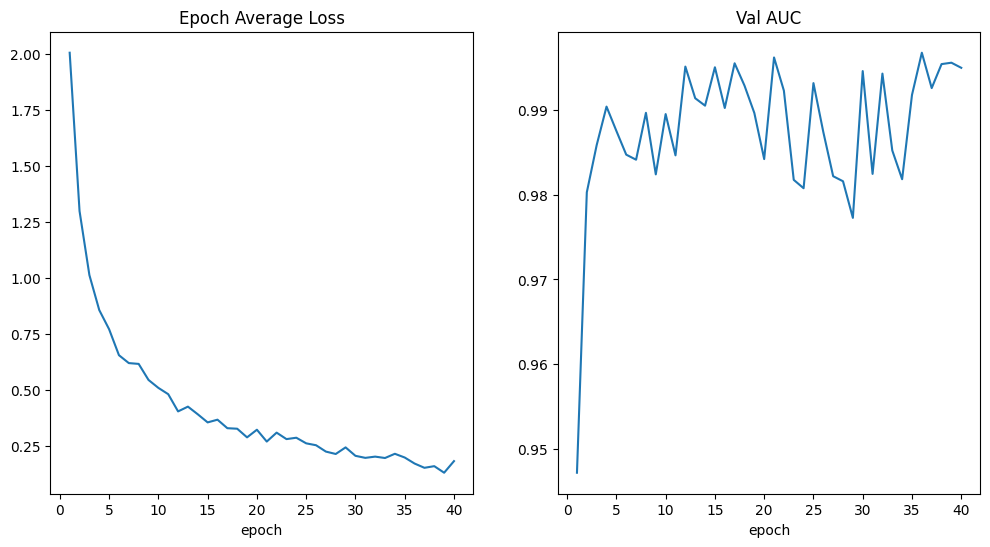

In [50]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [51]:
model.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [52]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.6207    0.5294    0.5714        68
           2     0.5733    0.6232    0.5972        69
           3     0.5063    0.6154    0.5556        65
           4     0.5593    0.5077    0.5323        65
           5     0.8986    0.9394    0.9185        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    0.9048    0.9500        21
           8     0.9048    0.9048    0.9048        21
           9     0.9242    0.8841    0.9037        69
          10     0.9275    0.9275    0.9275        69

    accuracy                         0.7721       610
   macro avg     0.8091    0.7935    0.7997       610
weighted avg     0.7773    0.7721    0.7731       610



In [301]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'sagittal_full_pretrained_seed{seed}.csv')

In [53]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 191.74 MB
Max VRAM used during training: 236.69 MB


## Unpretrained

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

In [55]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "sagittal_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.8226
1


Epochs:   2%|▎         | 1/40 [00:17<11:19, 17.43s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9776 current accuracy: 0.6957 best AUC: 0.9776 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.2632
1


Epochs:   5%|▌         | 2/40 [00:34<11:05, 17.51s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9864 current accuracy: 0.7143 best AUC: 0.9864 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 1.0032
1


Epochs:   8%|▊         | 3/40 [00:52<10:48, 17.53s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9900 current accuracy: 0.7950 best AUC: 0.9900 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.9177


Epochs:  10%|█         | 4/40 [01:09<10:21, 17.25s/it]

1
current epoch: 4 current AUC: 0.9844 current accuracy: 0.7764 best AUC: 0.9900 at epoch: 3
----------
epoch 5/40
epoch 5 average loss: 0.7968


Epochs:  12%|█▎        | 5/40 [01:26<09:59, 17.12s/it]

1
current epoch: 5 current AUC: 0.9845 current accuracy: 0.7950 best AUC: 0.9900 at epoch: 3
----------
epoch 6/40
epoch 6 average loss: 0.7519


Epochs:  15%|█▌        | 6/40 [01:43<09:38, 17.01s/it]

1
current epoch: 6 current AUC: 0.9835 current accuracy: 0.8199 best AUC: 0.9900 at epoch: 3
----------
epoch 7/40
epoch 7 average loss: 0.6692


Epochs:  18%|█▊        | 7/40 [02:00<09:22, 17.05s/it]

1
current epoch: 7 current AUC: 0.9868 current accuracy: 0.8012 best AUC: 0.9900 at epoch: 3
----------
epoch 8/40
epoch 8 average loss: 0.6004


Epochs:  20%|██        | 8/40 [02:17<09:04, 17.02s/it]

1
current epoch: 8 current AUC: 0.9854 current accuracy: 0.8261 best AUC: 0.9900 at epoch: 3
----------
epoch 9/40
epoch 9 average loss: 0.5470


Epochs:  22%|██▎       | 9/40 [02:34<08:47, 17.01s/it]

1
current epoch: 9 current AUC: 0.9860 current accuracy: 0.8323 best AUC: 0.9900 at epoch: 3
----------
epoch 10/40
epoch 10 average loss: 0.5717


Epochs:  25%|██▌       | 10/40 [02:50<08:28, 16.93s/it]

1
current epoch: 10 current AUC: 0.9803 current accuracy: 0.8075 best AUC: 0.9900 at epoch: 3
----------
epoch 11/40
epoch 11 average loss: 0.5196


Epochs:  28%|██▊       | 11/40 [03:07<08:10, 16.93s/it]

1
current epoch: 11 current AUC: 0.9868 current accuracy: 0.7950 best AUC: 0.9900 at epoch: 3
----------
epoch 12/40
epoch 12 average loss: 0.4941
1


Epochs:  30%|███       | 12/40 [03:25<07:59, 17.12s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9917 current accuracy: 0.8199 best AUC: 0.9917 at epoch: 12
----------
epoch 13/40
epoch 13 average loss: 0.4587


Epochs:  32%|███▎      | 13/40 [03:42<07:41, 17.08s/it]

1
current epoch: 13 current AUC: 0.9869 current accuracy: 0.8137 best AUC: 0.9917 at epoch: 12
----------
epoch 14/40
epoch 14 average loss: 0.4223


Epochs:  35%|███▌      | 14/40 [03:59<07:23, 17.05s/it]

1
current epoch: 14 current AUC: 0.9879 current accuracy: 0.7640 best AUC: 0.9917 at epoch: 12
----------
epoch 15/40
epoch 15 average loss: 0.4129
1


Epochs:  38%|███▊      | 15/40 [04:16<07:09, 17.16s/it]

saved new best metric model
current epoch: 15 current AUC: 0.9944 current accuracy: 0.9006 best AUC: 0.9944 at epoch: 15
----------
epoch 16/40
epoch 16 average loss: 0.3779


Epochs:  40%|████      | 16/40 [04:33<06:50, 17.10s/it]

1
current epoch: 16 current AUC: 0.9871 current accuracy: 0.8447 best AUC: 0.9944 at epoch: 15
----------
epoch 17/40
epoch 17 average loss: 0.3451


Epochs:  42%|████▎     | 17/40 [04:50<06:33, 17.11s/it]

1
current epoch: 17 current AUC: 0.9850 current accuracy: 0.8199 best AUC: 0.9944 at epoch: 15
----------
epoch 18/40
epoch 18 average loss: 0.2831


Epochs:  45%|████▌     | 18/40 [05:08<06:16, 17.12s/it]

1
current epoch: 18 current AUC: 0.9920 current accuracy: 0.8758 best AUC: 0.9944 at epoch: 15
----------
epoch 19/40
epoch 19 average loss: 0.3265


Epochs:  48%|████▊     | 19/40 [05:25<06:00, 17.16s/it]

1
current epoch: 19 current AUC: 0.9912 current accuracy: 0.8509 best AUC: 0.9944 at epoch: 15
----------
epoch 20/40
epoch 20 average loss: 0.2668
1


Epochs:  50%|█████     | 20/40 [05:42<05:45, 17.26s/it]

saved new best metric model
current epoch: 20 current AUC: 0.9948 current accuracy: 0.8758 best AUC: 0.9948 at epoch: 20
----------
epoch 21/40
epoch 21 average loss: 0.2971


Epochs:  52%|█████▎    | 21/40 [05:59<05:27, 17.22s/it]

1
current epoch: 21 current AUC: 0.9811 current accuracy: 0.7826 best AUC: 0.9948 at epoch: 20
----------
epoch 22/40
epoch 22 average loss: 0.2473


Epochs:  55%|█████▌    | 22/40 [06:16<05:09, 17.18s/it]

1
current epoch: 22 current AUC: 0.9885 current accuracy: 0.8385 best AUC: 0.9948 at epoch: 20
----------
epoch 23/40
epoch 23 average loss: 0.2831
1


Epochs:  57%|█████▊    | 23/40 [06:34<04:53, 17.26s/it]

saved new best metric model
current epoch: 23 current AUC: 0.9973 current accuracy: 0.9006 best AUC: 0.9973 at epoch: 23
----------
epoch 24/40
epoch 24 average loss: 0.2804


Epochs:  60%|██████    | 24/40 [06:51<04:34, 17.14s/it]

1
current epoch: 24 current AUC: 0.9941 current accuracy: 0.8820 best AUC: 0.9973 at epoch: 23
----------
epoch 25/40
epoch 25 average loss: 0.2707


Epochs:  62%|██████▎   | 25/40 [07:08<04:17, 17.14s/it]

1
current epoch: 25 current AUC: 0.9940 current accuracy: 0.9006 best AUC: 0.9973 at epoch: 23
----------
epoch 26/40
epoch 26 average loss: 0.2093


Epochs:  65%|██████▌   | 26/40 [07:25<03:59, 17.09s/it]

1
current epoch: 26 current AUC: 0.9852 current accuracy: 0.8634 best AUC: 0.9973 at epoch: 23
----------
epoch 27/40
epoch 27 average loss: 0.2086
1


Epochs:  68%|██████▊   | 27/40 [07:42<03:43, 17.20s/it]

saved new best metric model
current epoch: 27 current AUC: 0.9976 current accuracy: 0.9068 best AUC: 0.9976 at epoch: 27
----------
epoch 28/40
epoch 28 average loss: 0.2121


Epochs:  70%|███████   | 28/40 [07:59<03:25, 17.13s/it]

1
current epoch: 28 current AUC: 0.9886 current accuracy: 0.8385 best AUC: 0.9976 at epoch: 27
----------
epoch 29/40
epoch 29 average loss: 0.1896


Epochs:  72%|███████▎  | 29/40 [08:16<03:07, 17.07s/it]

1
current epoch: 29 current AUC: 0.9926 current accuracy: 0.8758 best AUC: 0.9976 at epoch: 27
----------
epoch 30/40
epoch 30 average loss: 0.2132


Epochs:  75%|███████▌  | 30/40 [08:33<02:50, 17.08s/it]

1
current epoch: 30 current AUC: 0.9824 current accuracy: 0.8261 best AUC: 0.9976 at epoch: 27
----------
epoch 31/40
epoch 31 average loss: 0.2260


Epochs:  78%|███████▊  | 31/40 [08:50<02:32, 16.98s/it]

1
current epoch: 31 current AUC: 0.9813 current accuracy: 0.8447 best AUC: 0.9976 at epoch: 27
----------
epoch 32/40
epoch 32 average loss: 0.1440


Epochs:  80%|████████  | 32/40 [09:07<02:15, 16.95s/it]

1
current epoch: 32 current AUC: 0.9873 current accuracy: 0.8137 best AUC: 0.9976 at epoch: 27
----------
epoch 33/40
epoch 33 average loss: 0.1695


Epochs:  82%|████████▎ | 33/40 [09:24<01:58, 16.96s/it]

1
current epoch: 33 current AUC: 0.9837 current accuracy: 0.8385 best AUC: 0.9976 at epoch: 27
----------
epoch 34/40
epoch 34 average loss: 0.1829


Epochs:  85%|████████▌ | 34/40 [09:41<01:41, 16.96s/it]

1
current epoch: 34 current AUC: 0.9848 current accuracy: 0.8323 best AUC: 0.9976 at epoch: 27
----------
epoch 35/40
epoch 35 average loss: 0.1647


Epochs:  88%|████████▊ | 35/40 [09:58<01:24, 16.93s/it]

1
current epoch: 35 current AUC: 0.9878 current accuracy: 0.8447 best AUC: 0.9976 at epoch: 27
----------
epoch 36/40
epoch 36 average loss: 0.1583


Epochs:  90%|█████████ | 36/40 [10:15<01:07, 16.91s/it]

1
current epoch: 36 current AUC: 0.9835 current accuracy: 0.8447 best AUC: 0.9976 at epoch: 27
----------
epoch 37/40
epoch 37 average loss: 0.1635


Epochs:  92%|█████████▎| 37/40 [10:31<00:50, 16.86s/it]

1
current epoch: 37 current AUC: 0.9963 current accuracy: 0.9130 best AUC: 0.9976 at epoch: 27
----------
epoch 38/40
epoch 38 average loss: 0.1728


Epochs:  95%|█████████▌| 38/40 [10:48<00:33, 16.90s/it]

1
current epoch: 38 current AUC: 0.9902 current accuracy: 0.8634 best AUC: 0.9976 at epoch: 27
----------
epoch 39/40
epoch 39 average loss: 0.1453


Epochs:  98%|█████████▊| 39/40 [11:05<00:16, 16.96s/it]

1
current epoch: 39 current AUC: 0.9860 current accuracy: 0.8447 best AUC: 0.9976 at epoch: 27
----------
epoch 40/40
epoch 40 average loss: 0.1626
1


Epochs: 100%|██████████| 40/40 [11:23<00:00, 17.08s/it]

saved new best metric model
current epoch: 40 current AUC: 0.9981 current accuracy: 0.9193 best AUC: 0.9981 at epoch: 40
train completed, best_metric: 0.9981 at epoch: 40


In [56]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")

Training time: 683.38 seconds
CPU time used: 8162.74 seconds
Memory used: 277.59 MB
GPU Memory Used: 194.89 MB
Max GPU Memory Used: 255.69 MB


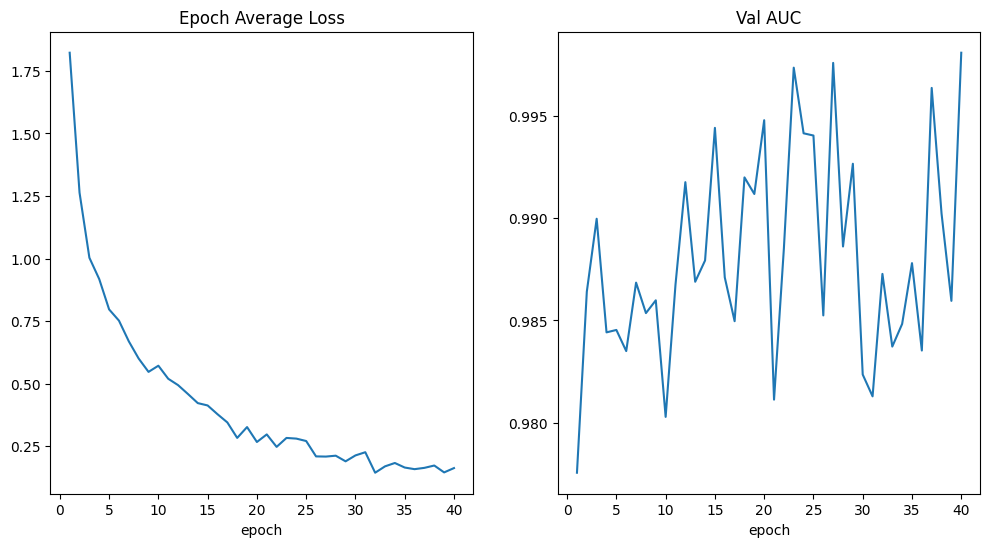

In [57]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [58]:
model.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [59]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.6238    0.9130    0.7412        69
           1     0.4861    0.5147    0.5000        68
           2     0.4706    0.3478    0.4000        69
           3     0.3667    0.3385    0.3520        65
           4     0.3636    0.1846    0.2449        65
           5     0.6173    0.7576    0.6803        66
           6     0.3200    0.2857    0.3019        28
           7     0.8889    0.3810    0.5333        21
           8     0.7333    0.5238    0.6111        21
           9     0.5625    0.7826    0.6545        69
          10     0.4179    0.4058    0.4118        69

    accuracy                         0.5164       610
   macro avg     0.5319    0.4941    0.4937       610
weighted avg     0.5040    0.5164    0.4959       610



In [307]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'sagittal_full_unpretrained_seed{seed}.csv')

In [60]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 194.88 MB
Max VRAM used during training: 255.69 MB


# Using 2d models as a backbone

In [61]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [62]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):

        axial = x[:, 0].to(torch.float32)
        coronal = x[:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, 0].permute(0, 3, 1, 2).to(torch.float32)

        axial_features = self.model_axial(axial)  # Output: [batch_size, 512, 1, 1]
        coronal_features = self.model_coronal(coronal)
        sagittal_features = self.model_sagittal(sagittal)

        axial_features = axial_features.view(axial_features.size(0), -1)  # [batch_size, 512]
        coronal_features = coronal_features.view(coronal_features.size(0), -1)
        sagittal_features = sagittal_features.view(sagittal_features.size(0), -1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

## Evaluation on a 3d dataset

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [65]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [66]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.216112836714714
Epoch 2, Loss: 1.730905125218053
Epoch 3, Loss: 1.3667570852464246
Epoch 4, Loss: 1.0863025323037179
Epoch 5, Loss: 0.878275946263344
Epoch 6, Loss: 0.7226675018187492
Epoch 7, Loss: 0.6219286620616913
Epoch 8, Loss: 0.5166788005059765
Epoch 9, Loss: 0.44633019355035597
Epoch 10, Loss: 0.40707952360953054
Epoch 11, Loss: 0.3628287959483362
Epoch 12, Loss: 0.3195643987386457
Epoch 13, Loss: 0.2994483411312103
Epoch 14, Loss: 0.26817760928984613
Epoch 15, Loss: 0.23897707318106004
Epoch 16, Loss: 0.24199412763118744
Epoch 17, Loss: 0.2088637299114658
Epoch 18, Loss: 0.19227267753693364
Epoch 19, Loss: 0.1820040378839739
Epoch 20, Loss: 0.17333398543057904
Epoch 21, Loss: 0.16261031743018858
Epoch 22, Loss: 0.15429093496453378
Epoch 23, Loss: 0.14306058302041022
Epoch 24, Loss: 0.14009309872504203
Epoch 25, Loss: 0.12320786690519701
Epoch 26, Loss: 0.12418246461499122
Epoch 27, Loss: 0.12107958836901572
Epoch 28, Loss: 0.11307240109289846
Epoch 29, Loss: 0

In [67]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 57.38 seconds
CPU time used: 687.89 seconds
Memory used: 67.11 MB
GPU Memory Used: 398.54 MB
Max GPU Memory Used: 1206.10 MB


In [68]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 398.54 MB
Max VRAM used during training: 1206.10 MB


In [69]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [70]:
combined_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = combined_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9923


In [71]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9710    0.9853        69
           1     0.8730    0.8088    0.8397        68
           2     0.7647    0.7536    0.7591        69
           3     0.8636    0.8769    0.8702        65
           4     0.8710    0.8308    0.8504        65
           5     0.7342    0.8788    0.8000        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.8923    0.8406    0.8657        69
          10     0.9041    0.9565    0.9296        69

    accuracy                         0.8754       610
   macro avg     0.9003    0.8918    0.8949       610
weighted avg     0.8792    0.8754    0.8761       610



In [317]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'combined_unpretrained_full_seed{seed}.csv')

In [72]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 399.16 MB
Max VRAM used during training: 1206.10 MB


### Pretrained

In [73]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [74]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [75]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [76]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(30), desc="Epochs"):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:43,  1.50s/it]

Epoch 1, Loss: 2.352969954090734


Epochs:   7%|▋         | 2/30 [00:02<00:39,  1.42s/it]

Epoch 2, Loss: 1.8668698610798005


Epochs:  10%|█         | 3/30 [00:04<00:37,  1.40s/it]

Epoch 3, Loss: 1.4945671712198565


Epochs:  13%|█▎        | 4/30 [00:05<00:35,  1.38s/it]

Epoch 4, Loss: 1.2415438467456448


Epochs:  17%|█▋        | 5/30 [00:06<00:34,  1.38s/it]

Epoch 5, Loss: 1.0417762225674045


Epochs:  20%|██        | 6/30 [00:08<00:32,  1.37s/it]

Epoch 6, Loss: 0.9030197993401559


Epochs:  23%|██▎       | 7/30 [00:09<00:31,  1.37s/it]

Epoch 7, Loss: 0.8155144895276716


Epochs:  27%|██▋       | 8/30 [00:11<00:30,  1.37s/it]

Epoch 8, Loss: 0.7394945236944384


Epochs:  30%|███       | 9/30 [00:12<00:28,  1.37s/it]

Epoch 9, Loss: 0.6556063823161586


Epochs:  33%|███▎      | 10/30 [00:13<00:27,  1.37s/it]

Epoch 10, Loss: 0.6265564022525665


Epochs:  37%|███▋      | 11/30 [00:15<00:26,  1.37s/it]

Epoch 11, Loss: 0.6028657843989711


Epochs:  40%|████      | 12/30 [00:16<00:24,  1.37s/it]

Epoch 12, Loss: 0.5593404500715194


Epochs:  43%|████▎     | 13/30 [00:17<00:23,  1.37s/it]

Epoch 13, Loss: 0.5197487223532892


Epochs:  47%|████▋     | 14/30 [00:19<00:21,  1.37s/it]

Epoch 14, Loss: 0.4998627910690923


Epochs:  50%|█████     | 15/30 [00:20<00:20,  1.37s/it]

Epoch 15, Loss: 0.4829869914439417


Epochs:  53%|█████▎    | 16/30 [00:22<00:19,  1.37s/it]

Epoch 16, Loss: 0.4545632793057349


Epochs:  57%|█████▋    | 17/30 [00:23<00:17,  1.37s/it]

Epoch 17, Loss: 0.43483640301612114


Epochs:  60%|██████    | 18/30 [00:24<00:16,  1.37s/it]

Epoch 18, Loss: 0.4174547858776585


Epochs:  63%|██████▎   | 19/30 [00:26<00:15,  1.37s/it]

Epoch 19, Loss: 0.4029086160082971


Epochs:  67%|██████▋   | 20/30 [00:27<00:13,  1.37s/it]

Epoch 20, Loss: 0.39748052964287417


Epochs:  70%|███████   | 21/30 [00:28<00:12,  1.37s/it]

Epoch 21, Loss: 0.39242559767538504


Epochs:  73%|███████▎  | 22/30 [00:30<00:10,  1.36s/it]

Epoch 22, Loss: 0.35819785921804365


Epochs:  77%|███████▋  | 23/30 [00:31<00:09,  1.36s/it]

Epoch 23, Loss: 0.36661058327844065


Epochs:  80%|████████  | 24/30 [00:32<00:08,  1.36s/it]

Epoch 24, Loss: 0.35242813681402513


Epochs:  83%|████████▎ | 25/30 [00:34<00:06,  1.36s/it]

Epoch 25, Loss: 0.32825248039537863


Epochs:  87%|████████▋ | 26/30 [00:35<00:05,  1.36s/it]

Epoch 26, Loss: 0.33076654374599457


Epochs:  90%|█████████ | 27/30 [00:37<00:04,  1.36s/it]

Epoch 27, Loss: 0.3030235623159716


Epochs:  93%|█████████▎| 28/30 [00:38<00:02,  1.36s/it]

Epoch 28, Loss: 0.3143963462883426


Epochs:  97%|█████████▋| 29/30 [00:39<00:01,  1.36s/it]

Epoch 29, Loss: 0.3104210231573351


Epochs: 100%|██████████| 30/30 [00:41<00:00,  1.37s/it]

Epoch 30, Loss: 0.29421213125028917


In [77]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 41.10 seconds
CPU time used: 492.54 seconds
Memory used: 39.88 MB
GPU Memory Used: 128.44 MB
Max GPU Memory Used: 679.60 MB


In [78]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 128.44 MB
Max VRAM used during training: 679.60 MB


In [79]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9992


In [80]:
combined_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = combined_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9835


In [81]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9324    1.0000    0.9650        69
           1     0.7619    0.7059    0.7328        68
           2     0.8302    0.6377    0.7213        69
           3     0.7833    0.7231    0.7520        65
           4     0.7160    0.8923    0.7945        65
           5     0.8406    0.8788    0.8593        66
           6     1.0000    0.8571    0.9231        28
           7     1.0000    1.0000    1.0000        21
           8     0.9130    1.0000    0.9545        21
           9     0.8955    0.8696    0.8824        69
          10     0.8533    0.9275    0.8889        69

    accuracy                         0.8426       610
   macro avg     0.8660    0.8629    0.8613       610
weighted avg     0.8446    0.8426    0.8402       610



In [325]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'combined_pretrained_full_seed{seed}.csv')

In [82]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 128.44 MB
Max VRAM used during training: 679.60 MB


## Balanced concatenation

In [14]:
def extract_metrics(file_path, has_auc=False):
    df = pd.read_csv(file_path)
    metrics = df.loc[df.index[-3], 'precision']
    return metrics

In [15]:
model_names = ['axial_full_unpretrained', 'coronal_full_unpretrained', 'sagittal_full_unpretrained']
csv_files = {
    model: glob.glob(f"{model}_seed{seed}.csv")
    for model in model_names
}

In [16]:
results = {}
for model, files in csv_files.items():
    model_metrics = []
    for file in files:
        metrics = extract_metrics(file)
    results[model] = metrics

In [17]:
results

{'axial_full_unpretrained': 0.8147540983606557,
 'coronal_full_unpretrained': 0.2770491803278688,
 'sagittal_full_unpretrained': 0.5836065573770491}

In [23]:
accuracies = list(results.values())
total_acc = sum(accuracies)
print([acc / total_acc for acc in accuracies])

[0.48630136986301364, 0.1653620352250489, 0.34833659491193736]


In [33]:
class BalancedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, accuracies, num_classes=n_classes):
        super(BalancedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        total_acc = sum(accuracies)
        self.weights = [acc / total_acc for acc in accuracies]
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):

        axial = x[:, 0].to(torch.float32)
        coronal = x[:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, 0].permute(0, 3, 1, 2).to(torch.float32)

        axial_features = self.model_axial(axial)  # Output: [batch_size, 512, 1, 1]
        coronal_features = self.model_coronal(coronal)
        sagittal_features = self.model_sagittal(sagittal)

        axial_features = axial_features.view(axial_features.size(0), -1)  # [batch_size, 512]
        coronal_features = coronal_features.view(coronal_features.size(0), -1)
        sagittal_features = sagittal_features.view(sagittal_features.size(0), -1)

        # Weights balancing
        weighted_features = (self.weights[0] * axial_features + self.weights[1] * coronal_features + 
                             self.weights[2] * sagittal_features)

        # Final classification
        out = self.fc(weighted_features)
        return out

In [34]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [35]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
balanced_model = BalancedResNetModel(model_axial, model_coronal, model_sagittal, accuracies=list(results.values()),
                                     num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(balanced_model.fc.parameters(), lr=0.0005)

In [37]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    balanced_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = balanced_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 1.8999605563379103
Epoch 2, Loss: 1.033922710726338
Epoch 3, Loss: 0.5847124236245309
Epoch 4, Loss: 0.40552124092655795
Epoch 5, Loss: 0.2923865323105166
Epoch 6, Loss: 0.23711171025230038
Epoch 7, Loss: 0.1923451716861417
Epoch 8, Loss: 0.16534753888845444
Epoch 9, Loss: 0.14588562495285465
Epoch 10, Loss: 0.12212084714443452
Epoch 11, Loss: 0.1148696419212126
Epoch 12, Loss: 0.10458903255001191
Epoch 13, Loss: 0.09205593973878891
Epoch 14, Loss: 0.08712759818280896
Epoch 15, Loss: 0.0905728408646199
Epoch 16, Loss: 0.07334738753495677
Epoch 17, Loss: 0.07251184878330078
Epoch 18, Loss: 0.06793098259837396
Epoch 19, Loss: 0.060248824437299085
Epoch 20, Loss: 0.058020730773287434
Epoch 21, Loss: 0.052121152860983726
Epoch 22, Loss: 0.05692808456238239
Epoch 23, Loss: 0.052042908515901334
Epoch 24, Loss: 0.05057350233677895
Epoch 25, Loss: 0.04543881247481031
Epoch 26, Loss: 0.042955998811990984
Epoch 27, Loss: 0.043787294277741064
Epoch 28, Loss: 0.042398351545055064
Ep

In [38]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 60.50 seconds
CPU time used: 725.00 seconds
Memory used: -63.76 MB
GPU Memory Used: 506.31 MB
Max GPU Memory Used: 1440.64 MB


In [39]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 506.31 MB
Max VRAM used during training: 1440.64 MB


In [40]:
balanced_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = balanced_model(val_images.to(device), )
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [41]:
balanced_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = balanced_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9920


In [42]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9853    0.9710    0.9781        69
           1     0.8209    0.8088    0.8148        68
           2     0.7778    0.7101    0.7424        69
           3     0.8529    0.8923    0.8722        65
           4     0.9180    0.8615    0.8889        65
           5     0.8194    0.8939    0.8551        66
           6     1.0000    0.9286    0.9630        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9091    0.8696    0.8889        69
          10     0.8571    0.9565    0.9041        69

    accuracy                         0.8820       610
   macro avg     0.9037    0.8993    0.9007       610
weighted avg     0.8829    0.8820    0.8815       610



In [43]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'balanced_unpretrained_full_seed{seed}.csv')

In [44]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 506.93 MB
Max VRAM used during training: 1440.64 MB


### Pretrained

In [45]:
model_names = ['axial_full_pretrained', 'coronal_full_pretrained', 'sagittal_full_pretrained']
csv_files = {
    model: glob.glob(f"{model}_seed{seed}.csv")
    for model in model_names
}

In [46]:
results = {}
for model, files in csv_files.items():
    model_metrics = []
    for file in files:
        metrics = extract_metrics(file)
    results[model] = metrics

In [47]:
results

{'axial_full_pretrained': 0.8918032786885246,
 'coronal_full_pretrained': 0.7573770491803279,
 'sagittal_full_pretrained': 0.7475409836065574}

In [48]:
accuracies = list(results.values())
total_acc = sum(accuracies)
print([acc / total_acc for acc in accuracies])

[0.37209302325581395, 0.31600547195622436, 0.3119015047879617]


In [49]:
# Load the pretrained models for each slice direction
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [50]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [51]:
balanced_model = BalancedResNetModel(model_axial, model_coronal, model_sagittal, accuracies=list(results.values()),
                                     num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(balanced_model.fc.parameters(), lr=0.0005)

In [52]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    balanced_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = balanced_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 1.9417573751941803
Epoch 2, Loss: 1.2543087986207777
Epoch 3, Loss: 0.9944763548912541
Epoch 4, Loss: 0.8658871593013886
Epoch 5, Loss: 0.7898576413431475
Epoch 6, Loss: 0.7455700635910034
Epoch 7, Loss: 0.7062094067373583
Epoch 8, Loss: 0.6266705191904499
Epoch 9, Loss: 0.6203342926117682
Epoch 10, Loss: 0.5863010633376337
Epoch 11, Loss: 0.5898904579301034
Epoch 12, Loss: 0.5521371604934815
Epoch 13, Loss: 0.5388854097935462
Epoch 14, Loss: 0.5413991347435982
Epoch 15, Loss: 0.5115275344540996
Epoch 16, Loss: 0.5025590562051342
Epoch 17, Loss: 0.4994135816251078
Epoch 18, Loss: 0.48591208169537203
Epoch 19, Loss: 0.4537108819330892
Epoch 20, Loss: 0.4539449541799484
Epoch 21, Loss: 0.4323970358217916
Epoch 22, Loss: 0.46259064972400665
Epoch 23, Loss: 0.4131197092994567
Epoch 24, Loss: 0.4149175771782475
Epoch 25, Loss: 0.39626111955411975
Epoch 26, Loss: 0.4140382423516243
Epoch 27, Loss: 0.409736939014927
Epoch 28, Loss: 0.39236398569999204
Epoch 29, Loss: 0.38797207

In [53]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 45.84 seconds
CPU time used: 549.08 seconds
Memory used: 14.22 MB
GPU Memory Used: 325.43 MB
Max GPU Memory Used: 872.50 MB


In [54]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 325.43 MB
Max VRAM used during training: 872.50 MB


In [55]:
balanced_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = balanced_model(val_images.to(device), )
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9981


In [56]:
balanced_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = balanced_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9719


In [57]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9571    0.9710    0.9640        69
           1     0.7241    0.6176    0.6667        68
           2     0.7045    0.4493    0.5487        69
           3     0.7333    0.8462    0.7857        65
           4     0.9038    0.7231    0.8034        65
           5     0.7436    0.8788    0.8056        66
           6     0.9643    0.9643    0.9643        28
           7     0.9130    1.0000    0.9545        21
           8     1.0000    0.9048    0.9500        21
           9     0.7973    0.8551    0.8252        69
          10     0.6966    0.8986    0.7848        69

    accuracy                         0.8000       610
   macro avg     0.8307    0.8281    0.8230       610
weighted avg     0.8027    0.8000    0.7939       610



In [58]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'balanced_pretrained_full_seed{seed}.csv')

In [59]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 325.43 MB
Max VRAM used during training: 872.50 MB


## Weighted concatenation

In [80]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):

        axial = x[:, 0].to(torch.float32)
        coronal = x[:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, 0].permute(0, 3, 1, 2).to(torch.float32)
        
        features_axial = self.model_axial(axial).flatten(1)
        features_coronal = self.model_coronal(coronal).flatten(1)
        features_sagittal = self.model_sagittal(sagittal).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [81]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [86]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [87]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [88]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(30), desc="Epochs"):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(torch.float32).to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:54,  1.87s/it]

Epoch 1, Loss: 2.302512691866967


Epochs:   7%|▋         | 2/30 [00:03<00:52,  1.87s/it]

Epoch 2, Loss: 2.022342512684484


Epochs:  10%|█         | 3/30 [00:05<00:50,  1.87s/it]

Epoch 3, Loss: 1.7834560755760438


Epochs:  13%|█▎        | 4/30 [00:07<00:48,  1.87s/it]

Epoch 4, Loss: 1.581845921854819


Epochs:  17%|█▋        | 5/30 [00:09<00:46,  1.87s/it]

Epoch 5, Loss: 1.3964135762183898


Epochs:  20%|██        | 6/30 [00:11<00:44,  1.87s/it]

Epoch 6, Loss: 1.2340184642422585


Epochs:  23%|██▎       | 7/30 [00:13<00:43,  1.87s/it]

Epoch 7, Loss: 1.0929150312177596


Epochs:  27%|██▋       | 8/30 [00:14<00:41,  1.87s/it]

Epoch 8, Loss: 0.9831543141795743


Epochs:  30%|███       | 9/30 [00:16<00:39,  1.87s/it]

Epoch 9, Loss: 0.882766185268279


Epochs:  33%|███▎      | 10/30 [00:18<00:37,  1.87s/it]

Epoch 10, Loss: 0.7968504890318839


Epochs:  37%|███▋      | 11/30 [00:20<00:35,  1.87s/it]

Epoch 11, Loss: 0.7272400529153885


Epochs:  40%|████      | 12/30 [00:22<00:33,  1.87s/it]

Epoch 12, Loss: 0.6669195121334445


Epochs:  43%|████▎     | 13/30 [00:24<00:31,  1.87s/it]

Epoch 13, Loss: 0.6075377964204357


Epochs:  47%|████▋     | 14/30 [00:26<00:29,  1.87s/it]

Epoch 14, Loss: 0.5686536690881175


Epochs:  50%|█████     | 15/30 [00:28<00:28,  1.87s/it]

Epoch 15, Loss: 0.5105906359611019


Epochs:  53%|█████▎    | 16/30 [00:29<00:26,  1.87s/it]

Epoch 16, Loss: 0.48668938106106174


Epochs:  57%|█████▋    | 17/30 [00:31<00:24,  1.87s/it]

Epoch 17, Loss: 0.4470180869102478


Epochs:  60%|██████    | 18/30 [00:33<00:22,  1.87s/it]

Epoch 18, Loss: 0.43006606832627325


Epochs:  63%|██████▎   | 19/30 [00:35<00:20,  1.87s/it]

Epoch 19, Loss: 0.4007972142388744


Epochs:  67%|██████▋   | 20/30 [00:37<00:18,  1.87s/it]

Epoch 20, Loss: 0.3746545680107609


Epochs:  70%|███████   | 21/30 [00:39<00:16,  1.87s/it]

Epoch 21, Loss: 0.3578737108938156


Epochs:  73%|███████▎  | 22/30 [00:41<00:14,  1.87s/it]

Epoch 22, Loss: 0.33222713874232385


Epochs:  77%|███████▋  | 23/30 [00:43<00:13,  1.87s/it]

Epoch 23, Loss: 0.3274696954796391


Epochs:  80%|████████  | 24/30 [00:44<00:11,  1.87s/it]

Epoch 24, Loss: 0.2898466053508943


Epochs:  83%|████████▎ | 25/30 [00:46<00:09,  1.87s/it]

Epoch 25, Loss: 0.2877325194497262


Epochs:  87%|████████▋ | 26/30 [00:48<00:07,  1.87s/it]

Epoch 26, Loss: 0.2739486732790547


Epochs:  90%|█████████ | 27/30 [00:50<00:05,  1.87s/it]

Epoch 27, Loss: 0.2697911555728605


Epochs:  93%|█████████▎| 28/30 [00:52<00:03,  1.87s/it]

Epoch 28, Loss: 0.2561555274071232


Epochs:  97%|█████████▋| 29/30 [00:54<00:01,  1.87s/it]

Epoch 29, Loss: 0.23541015723059255


Epochs: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]

Epoch 30, Loss: 0.2336195409297943


In [89]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 56.17 seconds
CPU time used: 673.18 seconds
Memory used: 33.42 MB
GPU Memory Used: 382.77 MB
Max GPU Memory Used: 1082.58 MB


In [90]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 382.77 MB
Max VRAM used during training: 1082.58 MB


In [91]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(torch.float32).to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric = ROCAUCMetric()
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [92]:
hypernetwork.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = hypernetwork(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9915


In [93]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict = True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9855    0.9855    0.9855        69
           1     0.8793    0.7500    0.8095        68
           2     0.7429    0.7536    0.7482        69
           3     0.8636    0.8769    0.8702        65
           4     0.9286    0.8000    0.8595        65
           5     0.6860    0.8939    0.7763        66
           6     1.0000    0.8571    0.9231        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    1.0000    1.0000        21
           9     0.9062    0.8406    0.8722        69
          10     0.9054    0.9710    0.9371        69

    accuracy                         0.8689       610
   macro avg     0.8956    0.8844    0.8871       610
weighted avg     0.8768    0.8689    0.8697       610



In [41]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'weighted_unpretrained_full_seed{seed}.csv')

In [94]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 382.77 MB
Max VRAM used during training: 1082.58 MB


### Pretrained

In [82]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

<All keys matched successfully>

In [83]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [84]:
# start_time = time.time()
# process = psutil.Process()
# start_cpu = process.cpu_times()
# start_mem = process.memory_info().rss / 1024**2  # В MB

# if device.type == "cuda":
#     torch.cuda.synchronize()
#     torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(30), desc="Epochs"):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(torch.float32).to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:40,  1.38s/it]

Epoch 1, Loss: 2.2869581560934744


Epochs:   7%|▋         | 2/30 [00:02<00:38,  1.38s/it]

Epoch 2, Loss: 1.9932609219704904


Epochs:  10%|█         | 3/30 [00:04<00:37,  1.38s/it]

Epoch 3, Loss: 1.7728565585228704


Epochs:  13%|█▎        | 4/30 [00:05<00:36,  1.39s/it]

Epoch 4, Loss: 1.569939944051927


Epochs:  17%|█▋        | 5/30 [00:06<00:34,  1.39s/it]

Epoch 5, Loss: 1.421576407647902


Epochs:  20%|██        | 6/30 [00:08<00:33,  1.39s/it]

Epoch 6, Loss: 1.266111220082929


Epochs:  23%|██▎       | 7/30 [00:09<00:31,  1.39s/it]

Epoch 7, Loss: 1.1549558947163243


Epochs:  27%|██▋       | 8/30 [00:11<00:30,  1.39s/it]

Epoch 8, Loss: 1.0666554474061536


Epochs:  30%|███       | 9/30 [00:12<00:29,  1.39s/it]

Epoch 9, Loss: 0.9807772078821736


Epochs:  33%|███▎      | 10/30 [00:13<00:27,  1.39s/it]

Epoch 10, Loss: 0.9107878496569972


Epochs:  37%|███▋      | 11/30 [00:15<00:26,  1.39s/it]

Epoch 11, Loss: 0.8534549359352358


Epochs:  40%|████      | 12/30 [00:16<00:25,  1.39s/it]

Epoch 12, Loss: 0.8095048896728023


Epochs:  43%|████▎     | 13/30 [00:18<00:23,  1.39s/it]

Epoch 13, Loss: 0.7628990738622604


Epochs:  47%|████▋     | 14/30 [00:19<00:22,  1.39s/it]

Epoch 14, Loss: 0.7256015904488102


Epochs:  50%|█████     | 15/30 [00:20<00:20,  1.39s/it]

Epoch 15, Loss: 0.6949542049438723


Epochs:  53%|█████▎    | 16/30 [00:22<00:19,  1.39s/it]

Epoch 16, Loss: 0.6627045321849084


Epochs:  57%|█████▋    | 17/30 [00:23<00:18,  1.39s/it]

Epoch 17, Loss: 0.6354636175017203


Epochs:  60%|██████    | 18/30 [00:25<00:16,  1.40s/it]

Epoch 18, Loss: 0.6239103040387554


Epochs:  63%|██████▎   | 19/30 [00:26<00:15,  1.40s/it]

Epoch 19, Loss: 0.5988518970627938


Epochs:  67%|██████▋   | 20/30 [00:27<00:13,  1.39s/it]

Epoch 20, Loss: 0.5625177016181331


Epochs:  70%|███████   | 21/30 [00:29<00:12,  1.39s/it]

Epoch 21, Loss: 0.5448219910744698


Epochs:  73%|███████▎  | 22/30 [00:30<00:11,  1.39s/it]

Epoch 22, Loss: 0.521432493002184


Epochs:  77%|███████▋  | 23/30 [00:32<00:09,  1.40s/it]

Epoch 23, Loss: 0.5192329018346725


Epochs:  80%|████████  | 24/30 [00:33<00:08,  1.40s/it]

Epoch 24, Loss: 0.48214767632945893


Epochs:  83%|████████▎ | 25/30 [00:34<00:06,  1.39s/it]

Epoch 25, Loss: 0.508502536243008


Epochs:  87%|████████▋ | 26/30 [00:36<00:05,  1.39s/it]

Epoch 26, Loss: 0.4692178532000511


Epochs:  90%|█████████ | 27/30 [00:37<00:04,  1.39s/it]

Epoch 27, Loss: 0.4621356225782825


Epochs:  93%|█████████▎| 28/30 [00:38<00:02,  1.39s/it]

Epoch 28, Loss: 0.4504379216701754


Epochs:  97%|█████████▋| 29/30 [00:40<00:01,  1.39s/it]

Epoch 29, Loss: 0.44349864413661344


Epochs: 100%|██████████| 30/30 [00:41<00:00,  1.39s/it]

Epoch 30, Loss: 0.41668378537701023


In [85]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 2075.39 seconds
CPU time used: 24865.72 seconds
Memory used: -188.41 MB
GPU Memory Used: 203.92 MB
Max GPU Memory Used: 475.12 MB


In [86]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 203.92 MB
Max VRAM used during training: 475.12 MB


In [100]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(torch.float32).to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9991


In [101]:
hypernetwork.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = hypernetwork(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9841


In [102]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict = True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8961    1.0000    0.9452        69
           1     0.7143    0.7353    0.7246        68
           2     0.8269    0.6232    0.7107        69
           3     0.7391    0.7846    0.7612        65
           4     0.7794    0.8154    0.7970        65
           5     0.8507    0.8636    0.8571        66
           6     1.0000    0.9286    0.9630        28
           7     1.0000    0.9048    0.9500        21
           8     0.9500    0.9048    0.9268        21
           9     0.8889    0.8116    0.8485        69
          10     0.8481    0.9710    0.9054        69

    accuracy                         0.8361       610
   macro avg     0.8631    0.8493    0.8536       610
weighted avg     0.8379    0.8361    0.8341       610



In [342]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'weighted_pretrained_full_seed{seed}.csv')

In [103]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 204.50 MB
Max VRAM used during training: 645.53 MB
